 ## **Settings**

- Importazione delle librerie necessarie e impostazione dei percorsi.

In [1]:
# CELLA 1: Importazioni e Impostazioni di Base
import os
import sys
import random
import time
import pickle
import platform # Importazione diretta
import json # Per LLM
import requests # Per LLM
import logging # Per LLM

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.utils import k_hop_subgraph, to_networkx

from sklearn.linear_model import Ridge
from monai.utils import set_determinism

# Configura il logging di base
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Impostazione dei percorsi
_base_path = os.path.dirname(os.getcwd()) # Ottiene la directory genitore in modo cross-platform
if _base_path not in sys.path: # Evita aggiunte multiple se il notebook viene rieseguito
    sys.path.append(_base_path)

# Importare le librerie locali dopo aver modificato sys.path
# Assicurati che 'src' sia effettivamente in _base_path o che questa struttura sia corretta
try:
    from src.helpers.config import get_config
    from src.models.gnn import GraphSAGE, GAT, ChebNet # Assumendo che GraphSAGE e GAT non siano usati ma importati
except ImportError as e:
    logging.error(f"Errore nell'importare moduli da 'src': {e}. Verifica che _base_path ({_base_path}) sia corretto e contenga 'src'.")
    # Potresti voler sollevare l'eccezione qui o uscire se questi moduli sono critici
    # raise

 - Definizione dei percorsi

In [2]:
# ----------------------------------------------------------------------------------
# CELLA 2: Definizione dei Percorsi Specifici
# ----------------------------------------------------------------------------------
try:
    _config = get_config()
    data_folder = _config.get('DATA_FOLDER', 'data') # Aggiunto default per robustezza
    graph_folder_relative_to_data = _config.get('GRAPH_FOLDER', 'graphs')
    saved_folder = _config.get('SAVED_FOLDER', 'saved_models')
    reports_folder = _config.get('REPORT_FOLDER', 'reports')
    logs_folder = _config.get('LOG_FOLDER', 'logs')

    data_path = os.path.join(_base_path, data_folder)
    graph_path = os.path.join(data_path, graph_folder_relative_to_data)
    saved_path = os.path.join(_base_path, saved_folder)
    reports_path = os.path.join(_base_path, reports_folder)
    logs_path = os.path.join(_base_path, logs_folder)
    cache_path = os.path.join(_base_path, 'cache')

    # Crea le directory se non esistono
    for path_to_create in [data_path, graph_path, saved_path, reports_path, logs_path, cache_path]:
        os.makedirs(path_to_create, exist_ok=True)
    logging.info(f"Percorsi impostati. Cartella cache: {cache_path}")
except Exception as e:
    logging.error(f"Errore nell'ottenere la configurazione o definire i percorsi: {e}")
    # Imposta percorsi di fallback o esci se la configurazione è critica
    # raise

# 

2025-05-21 01:55:40,423 - INFO - Percorsi impostati. Cartella cache: /home/gianuca/Scrivania/Tesi/Progetto/brain-tumor-graph-segmentation-main/brain-tumor-graph-segmentation-main/cache


- Impostazione del seed per la riproducibilità

In [3]:
# CELLA 3: Impostazione Seed per Riproducibilità
# ----------------------------------------------------------------------------------
SEED = 3 # Definisci come costante
set_determinism(seed=SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
logging.info(f"Seed impostato a: {SEED}")


2025-05-21 01:55:40,445 - INFO - Seed impostato a: 3


- Definizione dei parametri del modello

In [4]:
# CELLA 4: Definizione dei Parametri del Modello
# ----------------------------------------------------------------------------------
# PARAMETRI CONDIVISI
num_node_features = 50
num_classes = 4
lr = 1e-4
weight_decay = 1e-5
dropout = 0.0 # .0 è float, 0 è int. float è corretto per il dropout.
hidden_channels = [512] * 7 # Modo più conciso per definire liste ripetute

# PARAMETRI SPECIFICI PER IL MODELLO CHEBNET
k_chebyshev = 4 # Rinomina per chiarezza con il nome del parametro del modello (K)


## **Caricamento del modello e dei dati**

- Creazione e inizializzazione del modello

In [5]:
# ----------------------------------------------------------------------------------
# CELLA 5: Creazione del Modello GNN
# ----------------------------------------------------------------------------------
# Utilizza le costanti definite sopra
model = ChebNet(
    in_channels=num_node_features,
    hidden_channels=hidden_channels,
    out_channels=num_classes,
    dropout=dropout,
    K=k_chebyshev # Usa k_chebyshev
)
logging.info(f"Modello creato: {model.__class__.__name__}")

# 

2025-05-21 01:55:40,607 - INFO - Modello creato: ChebNet


- Funzione per caricare i grafi

In [6]:
# ----------------------------------------------------------------------------------
# CELLA 6: Funzione Helper per Gestire node_idx
# ----------------------------------------------------------------------------------
def _preprocess_node_idx(node_idx_input):
    """Converte node_idx in tensore 1D e valore scalare."""
    if isinstance(node_idx_input, int):
        return torch.tensor([node_idx_input], dtype=torch.int64), node_idx_input
    elif isinstance(node_idx_input, torch.Tensor) and node_idx_input.dim() == 0:
        return node_idx_input.unsqueeze(0).to(torch.int64), node_idx_input.item()
    elif isinstance(node_idx_input, torch.Tensor) and node_idx_input.numel() == 1:
        return node_idx_input.to(torch.int64).view(1), node_idx_input.item() # Assicura 1D
    # Se è già un tensore con più elementi, prendiamo il primo per lo scalare
    # e assumiamo che il tensore sia già del formato corretto per k_hop_subgraph
    elif isinstance(node_idx_input, torch.Tensor):
        return node_idx_input.to(torch.int64), node_idx_input[0].item()
    else:
        raise TypeError(f"Tipo non supportato per node_idx: {type(node_idx_input)}")

In [7]:
# ----------------------------------------------------------------------------------
# CELLA 7: Funzione per Trovare e Caricare un Grafo
# ----------------------------------------------------------------------------------
def find_and_load_graph(graph_data_path, subject_id_to_load=None): # Rinomina argomenti
    """
    Trova e carica un grafo per l'analisi.
    """
    if subject_id_to_load is None:
        subject_dirs = [d for d in os.listdir(graph_data_path) if os.path.isdir(os.path.join(graph_data_path, d))]
        valid_subjects = []
        for subject_dir_name in subject_dirs[:100]: # Limita la ricerca per efficienza
            graph_file_path = os.path.join(graph_data_path, subject_dir_name, f"{subject_dir_name}.graph")
            if os.path.isfile(graph_file_path):
                valid_subjects.append(subject_dir_name)
                if len(valid_subjects) >= 10: # Raccoglie fino a 10 soggetti validi
                    break
        
        if not valid_subjects:
            raise FileNotFoundError(f"Nessun grafo trovato nella directory {graph_data_path}")
        subject_id_to_load = random.choice(valid_subjects)
    
    graph_file = os.path.join(graph_data_path, subject_id_to_load, f"{subject_id_to_load}.graph")
    if not os.path.isfile(graph_file):
        raise FileNotFoundError(f"File grafo non trovato per il soggetto {subject_id_to_load} in {graph_file}")
    
    logging.info(f"Caricamento grafo: {graph_file}")
    # Per Data objects di PyG, weights_only=False è spesso necessario.
    # Assicurati di fidarti della fonte dei file .graph
    loaded_data = torch.load(graph_file, weights_only=False) 
    
    return loaded_data, subject_id_to_load

- Caricamento di un grafo di esempio

In [8]:
# ----------------------------------------------------------------------------------
# CELLA 8: Caricamento Grafo di Esempio
# ----------------------------------------------------------------------------------
subject_id_target = "BraTS-GLI-01166-000"
try:
    data, subject_id = find_and_load_graph(graph_path, subject_id_target) # Passa graph_path esplicitamente
    logging.info(f"Grafo caricato con successo: {subject_id}")
except FileNotFoundError as e:
    logging.error(f"Errore nel caricare il grafo target: {e}")
    logging.info("Tentativo di caricamento di un grafo alternativo...")
    data, subject_id = find_and_load_graph(graph_path, None) # Passa graph_path
    logging.info(f"Grafo alternativo caricato: {subject_id}")

print(f"Numero di nodi: {data.x.shape[0]}")
print(f"Numero di archi: {data.edge_index.shape[1]}")
print(f"Numero di features per nodo: {data.x.shape[1]}")

2025-05-21 01:55:40,634 - INFO - Caricamento grafo: /home/gianuca/Scrivania/Tesi/Progetto/brain-tumor-graph-segmentation-main/brain-tumor-graph-segmentation-main/data/graphs/BraTS-GLI-01166-000/BraTS-GLI-01166-000.graph
2025-05-21 01:55:40,645 - INFO - Grafo caricato con successo: BraTS-GLI-01166-000


Numero di nodi: 2607
Numero di archi: 26070
Numero di features per nodo: 50


- Caricamento del modello pre-addestrato

In [9]:
# ----------------------------------------------------------------------------------
# CELLA 9: Caricamento Modello Pre-addestrato
# ----------------------------------------------------------------------------------
model_files = [f for f in os.listdir(saved_path) if 'CHEBNET' in f and f.endswith('_best.pth')]
if not model_files:
    raise FileNotFoundError(f"Nessun modello ChebNet pre-addestrato trovato in {saved_path}")

# Estrai timestamp e ordina (assumendo formato CHEBNET_timestamp_best.pth)
try:
    model_files.sort(key=lambda f: int(f.split('_')[1]))
except (IndexError, ValueError):
    logging.warning("Impossibile ordinare i file modello per timestamp, uso l'ultimo alfabeticamente.")

latest_model_file = model_files[-1] 
logging.info(f"Utilizzo del modello pre-addestrato: {latest_model_file}")
# weights_only=True è appropriato per state_dict
model.load_state_dict(torch.load(os.path.join(saved_path, latest_model_file), map_location=torch.device('cpu'), weights_only=True))
model.eval()
print(model) # Mostra struttura del modello


2025-05-21 01:55:40,651 - INFO - Utilizzo del modello pre-addestrato: CHEBNET_1739029370_best.pth


ChebNet(
  (layers): ModuleList(
    (0): ChebConv(50, 512, K=4, normalization=sym)
    (1-6): 6 x ChebConv(512, 512, K=4, normalization=sym)
    (7): ChebConv(512, 4, K=4, normalization=sym)
  )
  (dropout): Dropout(p=0.0, inplace=False)
)


- Verifica dell'accuratezza sul grafo

In [10]:
# ----------------------------------------------------------------------------------
# CELLA 10: Verifica Accuratezza sul Grafo Caricato
# ----------------------------------------------------------------------------------
with torch.no_grad():
    outputs = model(data.x, data.edge_index.type(torch.int64))
    predicted_labels = outputs.argmax(dim=1)
    node_classes = predicted_labels.clone() # Questo era definito qui, ok.
    
    accuracy_on_graph = float('nan') # Valore di default
    if hasattr(data, 'y') and data.y is not None:
        try:
            correct_predictions = (predicted_labels == data.y).float().sum()
            accuracy_on_graph = (correct_predictions / data.y.size(0)).item()
            print(f"Accuratezza sul grafo {subject_id}: {accuracy_on_graph:.4f}")
        except Exception as e:
            logging.warning(f"Impossibile calcolare l'accuratezza usando data.y: {e}")
            print("Usando solo le predizioni per l'analisi.")
    else:
        print("data.y non disponibile. Impossibile calcolare l'accuratezza.")
        print("Usando solo le predizioni per l'analisi.")
    
    class_counts = torch.bincount(predicted_labels, minlength=num_classes)
    print(f"Distribuzione classi predette: {class_counts.numpy()}")

Accuratezza sul grafo BraTS-GLI-01166-000: 1.0000
Distribuzione classi predette: [2550   16    4   37]


## **Implementazione di metodi avanzati di explainability**

- Implementazione semplificata dei metodi di explainability

In [11]:
# ----------------------------------------------------------------------------------
# CELLA 11: Metodi di Explainability Semplificati
# ----------------------------------------------------------------------------------
def gnn_explainer_simple(node_idx, x_features, edge_idx_graph, model_to_explain=model): # Rinomina args
    """Implementazione semplificata di GNNExplainer (saliency map)."""
    _, node_idx_scalar = _preprocess_node_idx(node_idx)
    x_grad = x_features.clone().detach().requires_grad_(True)
    
    with torch.enable_grad():
        model_output = model_to_explain(x_grad, edge_idx_graph.type(torch.int64))
        pred_class = model_output[node_idx_scalar].argmax().item()
        
        model_to_explain.zero_grad()
        model_output[node_idx_scalar, pred_class].backward()
        
        node_importance = x_grad.grad[node_idx_scalar].abs()
    return node_importance, pred_class

def gradcam_explainer(node_idx, x_features, edge_idx_graph, model_to_explain=model): # Rinomina args
    """Implementazione semplificata di GradCAM-like per GNN."""
    _, node_idx_scalar = _preprocess_node_idx(node_idx)
    x_grad = x_features.clone().detach().requires_grad_(True)
    
    with torch.enable_grad():
        model_output = model_to_explain(x_grad, edge_idx_graph.type(torch.int64))
        pred_class = model_output[node_idx_scalar].argmax().item()
        
        model_to_explain.zero_grad()
        model_output[node_idx_scalar, pred_class].backward()
        
        gradients = x_grad.grad[node_idx_scalar]
        # Pondera i gradienti con le feature stesse (una forma di attention/saliency)
        node_importance = (gradients * x_features[node_idx_scalar]).abs() 
    return node_importance, pred_class

# 

- Implementazione di GraphLIME

In [12]:
# ----------------------------------------------------------------------------------
# CELLA 12: Classe GraphLIME
# ----------------------------------------------------------------------------------
class GraphLIME:
    """GraphLIME."""
    def __init__(self, model_instance, num_samples=50, kernel_width=0.25):
        self.model = model_instance
        self.num_samples = num_samples
        self.kernel_width = kernel_width
        
    def explain_node(self, node_idx, x_features, edge_idx_graph, num_hops=2):
        node_idx_tensor, node_idx_scalar = _preprocess_node_idx(node_idx)
        edge_idx_graph_int64 = edge_idx_graph.type(torch.int64)
        
        nodes_subgraph, edge_index_sub, mapping_to_subgraph, _ = k_hop_subgraph(
            node_idx_tensor, num_hops, edge_idx_graph_int64, relabel_nodes=True
        )
        x_sub = x_features[nodes_subgraph]
        
        with torch.no_grad():
            original_pred = self.model(x_features, edge_idx_graph_int64)
            original_prob = torch.softmax(original_pred, dim=1)
            target_class = original_prob[node_idx_scalar].argmax().item()
            
        perturbed_node_features_list = []
        distances = []
        perturbed_predictions = []
        
        # Indice del nodo target all'interno del sottografo
        node_idx_in_subgraph = mapping_to_subgraph.item()

        for _ in range(self.num_samples):
            perturbed_x_sub_node = x_sub[node_idx_in_subgraph].clone()
            # Perturba solo le feature del nodo di interesse nel contesto del suo vicinato k-hop
            perturbation_mask = torch.bernoulli(torch.ones_like(perturbed_x_sub_node) * 0.5).bool()
            perturbed_x_sub_node[perturbation_mask] = torch.randn_like(perturbed_x_sub_node[perturbation_mask])
            
            distance = torch.sum((perturbed_x_sub_node - x_sub[node_idx_in_subgraph])**2).item()
            distances.append(distance)
            
            # Applica la perturbazione al grafo completo (solo per il nodo di interesse)
            x_features_perturbed_all = x_features.clone()
            x_features_perturbed_all[node_idx_scalar] = perturbed_x_sub_node # Modifica solo le feature del nodo target

            with torch.no_grad():
                pred_perturbed = self.model(x_features_perturbed_all, edge_idx_graph_int64)
                pred_prob_perturbed = torch.softmax(pred_perturbed, dim=1)[node_idx_scalar]
                perturbed_predictions.append(pred_prob_perturbed[target_class].item())
            
            perturbed_node_features_list.append(perturbed_x_sub_node.cpu().numpy().flatten())
        
        distances_np = np.array(distances)
        raw_weights = np.exp(-(distances_np ** 2) / (self.kernel_width ** 2))
        epsilon = 1e-8
        weights = raw_weights + epsilon
        if np.sum(weights) < epsilon * self.num_samples: # Se la somma è ancora troppo piccola
            weights = np.ones_like(weights) / len(weights)
        
        X_train = np.array(perturbed_node_features_list)
        y_train = np.array(perturbed_predictions)
        
        linear_model = Ridge(alpha=1.0, random_state=SEED) # Aggiunto random_state
        linear_model.fit(X_train, y_train, sample_weight=weights)
        
        feature_importance = np.abs(linear_model.coef_)
        return torch.tensor(feature_importance, dtype=torch.float32), target_class

# 

-Implementazione di Integrated Gradients

In [13]:
# ----------------------------------------------------------------------------------
# CELLA 13: Classe IntegratedGradients
# ----------------------------------------------------------------------------------
class IntegratedGradients:
    """Integrated Gradients."""
    def __init__(self, model_instance, steps=20):
        self.model = model_instance
        self.steps = steps
        
    def explain_node(self, node_idx, x_features, edge_idx_graph):
        _, node_idx_scalar = _preprocess_node_idx(node_idx)
        edge_idx_graph_int64 = edge_idx_graph.type(torch.int64)
        self.model.eval()
        
        baseline_x = torch.zeros_like(x_features) # Baseline per le feature
        input_x_node = x_features[node_idx_scalar].clone().detach()
        baseline_x_node = baseline_x[node_idx_scalar]

        with torch.no_grad():
            output_original = self.model(x_features, edge_idx_graph_int64)
            pred_class = output_original[node_idx_scalar].argmax().item()
        
        integrated_gradients_node = torch.zeros_like(input_x_node)
        
        for alpha in np.linspace(0.0, 1.0, self.steps, endpoint=True): # Endpoint=True è importante
            x_features_interpolated = x_features.clone().detach()
            # Interpola solo le feature del nodo target
            x_features_interpolated[node_idx_scalar] = baseline_x_node + alpha * (input_x_node - baseline_x_node)
            x_features_interpolated.requires_grad_(True)
            
            output_interpolated = self.model(x_features_interpolated, edge_idx_graph_int64)
            target_score = output_interpolated[node_idx_scalar, pred_class]
            
            self.model.zero_grad()
            target_score.backward() # Non serve retain_graph se ricalcoliamo il forward ogni volta
            
            if x_features_interpolated.grad is not None:
                integrated_gradients_node += x_features_interpolated.grad[node_idx_scalar]
            # Non serve x_features_interpolated.grad.zero_() perché x_features_interpolated è ricreata
            
        integrated_gradients_node /= self.steps # Media dei gradienti
        node_importance = integrated_gradients_node * (input_x_node - baseline_x_node)
        return node_importance.abs(), pred_class # Solitamente si prende l'assoluto o la somma


- Inizializzazione delle istanze dei metodi di explainability

In [14]:
# ----------------------------------------------------------------------------------
# CELLA 14: Inizializzazione Istanze Explainers
# ----------------------------------------------------------------------------------
graph_lime = GraphLIME(model, num_samples=50, kernel_width=0.25)
integrated_gradients = IntegratedGradients(model, steps=20)
logging.info("Istanze di GraphLIME e IntegratedGradients create.")

2025-05-21 01:55:42,089 - INFO - Istanze di GraphLIME e IntegratedGradients create.


## **Definizione del framework di valutazione**

In [15]:
# ----------------------------------------------------------------------------------
# CELLA 15: Classe ExplainabilityEvaluator
# ----------------------------------------------------------------------------------
class ExplainabilityEvaluator:
    """Valuta metodi di explainability."""
    def __init__(self, model_instance, graph_data_obj): # Rinomina argomenti
        self.model = model_instance
        self.data = graph_data_obj
        
    def evaluate_fidelity(self, explanation_importances, node_idx, k_features=10): # Rinomina
        _, node_idx_scalar = _preprocess_node_idx(node_idx)
        x, edge_index = self.data.x, self.data.edge_index.type(torch.int64)
        
        with torch.no_grad():
            original_output = self.model(x, edge_index)
            original_prob = torch.softmax(original_output, dim=1)
            target_class = original_prob[node_idx_scalar].argmax().item()
            original_score = original_prob[node_idx_scalar, target_class].item()
        
        if isinstance(explanation_importances, np.ndarray):
            explanation_importances = torch.tensor(explanation_importances, dtype=torch.float32)
        importance = explanation_importances.abs()
        
        if importance.numel() == 0 or importance.sum() == 0: return 0.0 # Caso limite
        
        # Assicurati che k_features non sia maggiore del numero di feature disponibili
        num_actual_features = importance.shape[0]
        k = min(k_features, num_actual_features)
        if k == 0: return 0.0

        _, top_indices = torch.topk(importance, k=k)
        
        x_perturbed = x.clone()
        x_perturbed[node_idx_scalar, top_indices] = 0
        
        with torch.no_grad():
            perturbed_output = self.model(x_perturbed, edge_index)
            perturbed_prob = torch.softmax(perturbed_output, dim=1)
            perturbed_score = perturbed_prob[node_idx_scalar, target_class].item()
        
        return original_score - perturbed_score
    
    def evaluate_sparsity(self, explanation_importances, threshold=0.1): # Rinomina
        if isinstance(explanation_importances, np.ndarray):
            explanation_importances = torch.tensor(explanation_importances, dtype=torch.float32)
        importance = explanation_importances.abs()

        if importance.numel() == 0 or importance.sum() == 0: return 1.0 # Massima sparsità se non ci sono importanze
        
        max_imp = importance.max()
        if max_imp > 0:
            importance_normalized = importance / max_imp
        else: # Tutte le importanze sono 0
            return 1.0 
        
        num_relevant = (importance_normalized > threshold).sum().item()
        total_features = importance.numel()
        
        return 1.0 - (num_relevant / total_features if total_features > 0 else 0)
    
    def evaluate_stability(self, explainer_obj, node_idx, x_features, edge_idx_graph, num_samples=5, noise_level=0.05): # Rinomina args
        _, node_idx_scalar = _preprocess_node_idx(node_idx)
        edge_idx_graph_int64 = edge_idx_graph.type(torch.int64) # Assicura tipo corretto
        
        # Ottieni spiegazione originale (passando x_features e edge_idx_graph)
        original_explanation, _ = explainer_obj.explain_node(node_idx_scalar, x_features, edge_idx_graph_int64)
        if isinstance(original_explanation, np.ndarray):
            original_explanation = torch.tensor(original_explanation, dtype=torch.float32)
        
        if original_explanation.numel() == 0 or original_explanation.std() == 0:
            # Se la spiegazione originale è vuota o costante, la stabilità non è ben definita o è 1.
            return 1.0 if original_explanation.numel() > 0 else 0.0


        correlations = []
        for _ in range(num_samples):
            x_noisy = x_features + noise_level * torch.randn_like(x_features)
            noisy_explanation, _ = explainer_obj.explain_node(node_idx_scalar, x_noisy, edge_idx_graph_int64)
            if isinstance(noisy_explanation, np.ndarray):
                noisy_explanation = torch.tensor(noisy_explanation, dtype=torch.float32)
            
            if noisy_explanation.numel() == 0 or noisy_explanation.std() == 0:
                correlations.append(0.0) # Nessuna correlazione se la spiegazione è nulla/costante
                continue

            orig_flat = original_explanation.flatten()
            noisy_flat = noisy_explanation.flatten()
            
            # Pearson correlation coefficient
            vx = orig_flat - torch.mean(orig_flat)
            vy = noisy_flat - torch.mean(noisy_flat)
            corr = torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)) * torch.sqrt(torch.sum(vy ** 2)) + 1e-8)
            correlations.append(corr.item())
        
        return sum(correlations) / len(correlations) if correlations else 0.0

## **Implementazione del framework di confronto**

In [16]:
# ----------------------------------------------------------------------------------
# CELLA 16: Funzione `simplified_compare_explainers`
# ----------------------------------------------------------------------------------
def simplified_compare_explainers(gnn_model, graph_data_obj, target_node_list, explainer_functions_dict, cache_dir=cache_path): # Rinomina
    """Confronta diversi metodi di explainability."""
    evaluator = ExplainabilityEvaluator(gnn_model, graph_data_obj)
    
    results_dict = {
        "fidelity": {name: [] for name in explainer_functions_dict},
        "sparsity": {name: [] for name in explainer_functions_dict},
        "stability": {name: [] for name in explainer_functions_dict}, # Sarà calcolata selettivamente
        "execution_time": {name: [] for name in explainer_functions_dict},
        "explanations": {name: {} for name in explainer_functions_dict},
        "predicted_classes": {name: {} for name in explainer_functions_dict}
    }
    
    # Funzioni explainer che sono metodi di classe e necessitano dell'istanza
    # (GraphLIME e IntegratedGradients sono già istanziati come graph_lime, integrated_gradients)
    explainer_instances = {
        "GraphLIME": graph_lime, # Istanza globale
        "IntegratedGradients": integrated_gradients # Istanza globale
    }

    for node_idx_val in target_node_list:
        logging.info(f"Analisi del nodo {node_idx_val}...")
        
        for name, explainer_func_or_method in explainer_functions_dict.items():
            logging.info(f"  Metodo: {name}")
            
            cache_file = os.path.join(cache_dir, f"{name}_node{node_idx_val}_subj{subject_id}.pkl") # Aggiunto subject_id per unicità cache
            if os.path.exists(cache_file):
                logging.info(f"  Caricamento spiegazione dalla cache: {cache_file}")
                with open(cache_file, 'rb') as f:
                    cached_data = pickle.load(f)
                explanation = cached_data['explanation']
                pred_class = cached_data['pred_class']
                exec_time = cached_data.get('exec_time', 0) # Prendi exec_time se presente, altrimenti 0
            else:
                start_time = time.time()
                explanation, pred_class = explainer_func_or_method(node_idx_val, graph_data_obj.x, graph_data_obj.edge_index)
                exec_time = time.time() - start_time
                
                with open(cache_file, 'wb') as f:
                    pickle.dump({
                        'explanation': explanation, 'pred_class': pred_class,
                        'node_idx': node_idx_val, 'method': name, 'exec_time': exec_time
                    }, f)
                logging.info(f"  Salvata spiegazione nella cache: {cache_file}")
            
            fidelity = evaluator.evaluate_fidelity(explanation, node_idx_val)
            sparsity = evaluator.evaluate_sparsity(explanation)
            
            stability = float('nan') # Default a NaN
            # Calcola stabilità solo per alcuni nodi e se l'explainer è un oggetto (per il metodo evaluate_stability)
            if node_idx_val % 5 == 0: # Esempio: ogni 5 nodi
                if name in explainer_instances:
                    explainer_obj = explainer_instances[name]
                    stability = evaluator.evaluate_stability(explainer_obj, node_idx_val, graph_data_obj.x, graph_data_obj.edge_index)
                    logging.info(f"    Stabilità ({name}): {stability:.4f}")
                else: # Se l'explainer è una funzione pura, la stabilità come definita potrebbe non applicarsi direttamente
                      # o richiederebbe di avvolgerla in un oggetto fittizio. Per ora la saltiamo.
                    logging.info(f"    Stabilità ({name}): Non calcolata (explainer non è un'istanza di classe nota).")
            
            results_dict["fidelity"][name].append(fidelity)
            results_dict["sparsity"][name].append(sparsity)
            results_dict["stability"][name].append(stability)
            results_dict["execution_time"][name].append(exec_time)
            results_dict["explanations"][name][node_idx_val] = explanation
            results_dict["predicted_classes"][name][node_idx_val] = pred_class
            
            logging.info(f"    Fedeltà: {fidelity:.4f}, Sparsità: {sparsity:.4f}, Tempo: {exec_time:.4f}s")
    
    for metric in ["fidelity", "sparsity", "stability", "execution_time"]:
        results_dict[f"avg_{metric}"] = {}
        for name in explainer_functions_dict:
            values = [v for v in results_dict[metric][name] if not (isinstance(v, float) and np.isnan(v))] # Escludi NaN dalla media
            results_dict[f"avg_{metric}"][name] = (sum(values) / len(values)) if values else float('nan')
            
    return results_dict


- Funzione per visualizzare i risultati del confronto

In [17]:
# CELLA 17 PER plot_explanation_comparison (COMPLETA E CORRETTA)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch 
import os 
import logging 

def plot_explanation_comparison(results_data, reports_output_path, target_nodes_list=None, figsize=(20, 18)):
    """
    Visualizza i risultati del confronto tra i diversi metodi di spiegabilità.
    """
    methods = list(results_data["fidelity"].keys())
    metrics_to_plot = ["fidelity", "sparsity"] 
    
    fig, axs = plt.subplots(2, 2, figsize=figsize)
    axs = axs.flatten()

    # Grafico a barre per le metriche medie
    avg_data_plot = {metric: [results_data[f"avg_{metric}"].get(method, 0) for method in methods] for metric in metrics_to_plot}
    df_avg = pd.DataFrame(avg_data_plot, index=methods)
    df_avg.plot(kind='bar', ax=axs[0], colormap='viridis')
    axs[0].set_title('Metriche medie per metodo di Explainability', fontsize=14)
    axs[0].set_ylabel('Punteggio Medio', fontsize=12)
    axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, ha='right')
    axs[0].legend(title='Metriche', fontsize=10)
    axs[0].grid(axis='y', linestyle='--')

    # Grafico a barre per i tempi di esecuzione medi
    avg_exec_times = [results_data["avg_execution_time"].get(method, 0) for method in methods]
    axs[1].bar(methods, avg_exec_times, color='lightcoral')
    axs[1].set_title('Tempo medio di esecuzione', fontsize=14)
    axs[1].set_ylabel('Secondi (media)', fontsize=12)
    axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, ha='right')
    axs[1].grid(axis='y', linestyle='--')

    # Boxplot per la distribuzione delle metriche
    data_for_boxplot = []
    boxplot_labels = []
    for metric in metrics_to_plot:
        for method in methods:
            values = [v for v in results_data[metric].get(method, []) if not (isinstance(v, float) and np.isnan(v))]
            if values:
                data_for_boxplot.append(values)
                boxplot_labels.append(f"{method}\n({metric})")
    
    if data_for_boxplot:
        axs[2].boxplot(data_for_boxplot, tick_labels=boxplot_labels, patch_artist=True, medianprops=dict(color="black"))
        axs[2].set_title('Distribuzione delle metriche', fontsize=14)
        axs[2].set_ylabel('Punteggio', fontsize=12)
        axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=45, ha='right') # Rimosso labelsize da qui
        axs[2].tick_params(axis='x', labelsize=10) # Aggiunto labelsize qui
        axs[2].grid(axis='y', linestyle='--')
    else:
        axs[2].text(0.5, 0.5, "Nessun dato per il boxplot.", horizontalalignment='center', verticalalignment='center')
        axs[2].set_title('Distribuzione delle metriche', fontsize=14)
        axs[2].axis('off')

    # Heatmap delle correlazioni
    nodes_for_corr = target_nodes_list
    if nodes_for_corr is None:
        if 'target_nodes_eval' in globals() and target_nodes_eval:
            nodes_for_corr = target_nodes_eval
        elif 'target_nodes' in globals() and target_nodes:
            nodes_for_corr = target_nodes
        else:
            nodes_for_corr = []

    if not nodes_for_corr:
        logging.warning("Nessuna lista di nodi target fornita o trovata globalmente per la heatmap di correlazione.")
        axs[3].text(0.5, 0.5, "Nodi target non disponibili\nper heatmap di correlazione.", horizontalalignment='center', verticalalignment='center')
        axs[3].set_title('Correlazione tra Spiegazioni', fontsize=14)
        axs[3].axis('off')
    else:
        num_methods = len(methods)
        corr_matrix_sum = np.zeros((num_methods, num_methods))
        counts_corr = np.zeros((num_methods, num_methods))

        for node_idx_val_corr in nodes_for_corr:
            for i, method1 in enumerate(methods):
                for j, method2 in enumerate(methods):
                    if i == j:
                        corr_matrix_sum[i, j] += 1.0
                        counts_corr[i, j] += 1
                        continue
                    
                    expl1_data = results_data["explanations"].get(method1, {}).get(node_idx_val_corr)
                    expl2_data = results_data["explanations"].get(method2, {}).get(node_idx_val_corr)

                    if expl1_data is None or expl2_data is None:
                        continue

                    expl1_t = expl1_data if isinstance(expl1_data, torch.Tensor) else torch.tensor(expl1_data, dtype=torch.float32)
                    expl2_t = expl2_data if isinstance(expl2_data, torch.Tensor) else torch.tensor(expl2_data, dtype=torch.float32)
                    
                    if expl1_t.numel() == 0 or expl2_t.numel() == 0 or expl1_t.std() == 0 or expl2_t.std() == 0:
                        continue

                    expl1_flat_t = expl1_t.flatten()
                    expl2_flat_t = expl2_t.flatten()
                    
                    vx_t = expl1_flat_t - torch.mean(expl1_flat_t)
                    vy_t = expl2_flat_t - torch.mean(expl2_flat_t)
                    std_vx = torch.sqrt(torch.sum(vx_t ** 2)) + 1e-8 
                    std_vy = torch.sqrt(torch.sum(vy_t ** 2)) + 1e-8
                    corr_val = torch.sum(vx_t * vy_t) / (std_vx * std_vy)
                    
                    if not torch.isnan(corr_val):
                         corr_matrix_sum[i, j] += corr_val.item()
                         counts_corr[i, j] += 1
        
        with np.errstate(divide='ignore', invalid='ignore'):
            corr_matrix_final = np.where(counts_corr > 0, corr_matrix_sum / counts_corr, 0)
        np.fill_diagonal(corr_matrix_final, 1.0)

        im = axs[3].imshow(corr_matrix_final, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
        axs[3].set_title('Correlazione Media tra Spiegazioni dei Metodi', fontsize=14)
        axs[3].set_xticks(np.arange(len(methods)))
        axs[3].set_yticks(np.arange(len(methods)))
        axs[3].set_xticklabels(methods, rotation=45, ha="right")
        axs[3].set_yticklabels(methods)
        plt.colorbar(im, ax=axs[3], fraction=0.046, pad=0.04)

        for i in range(len(methods)):
            for j in range(len(methods)):
                text_color = "white" if abs(corr_matrix_final[i, j]) > 0.5 else "black"
                axs[3].text(j, i, f"{corr_matrix_final[i, j]:.2f}", 
                            ha="center", va="center", color=text_color, fontsize=8)

    plt.tight_layout(pad=2.0)
    
    fig_path = os.path.join(reports_output_path, 'explainability_comparison_metrics_plot.png')
    try:
        plt.savefig(fig_path, dpi=300, bbox_inches='tight')
        logging.info(f"Plot di confronto dei metodi di explainability salvato in: {fig_path}")
    except Exception as e:
        logging.error(f"Errore durante il salvataggio del plot di confronto: {e}")
        
    plt.show()

## **Esecuzione dei metodi di explainability e confronto**

2025-05-21 02:07:25,469 - INFO - Avvio confronto metodi di explainability su 5 nodi...
2025-05-21 02:07:25,470 - INFO - Analisi del nodo 974...
2025-05-21 02:07:25,471 - INFO -   Metodo: GNNExplainer
2025-05-21 02:07:25,472 - INFO -   Caricamento spiegazione dalla cache: /home/gianuca/Scrivania/Tesi/Progetto/brain-tumor-graph-segmentation-main/brain-tumor-graph-segmentation-main/cache/GNNExplainer_node974_subjBraTS-GLI-01166-000.pkl
2025-05-21 02:07:28,041 - INFO -     Fedeltà: 0.0000, Sparsità: 0.7200, Tempo: 2.6087s
2025-05-21 02:07:28,042 - INFO -   Metodo: GradCAM
2025-05-21 02:07:28,043 - INFO -   Caricamento spiegazione dalla cache: /home/gianuca/Scrivania/Tesi/Progetto/brain-tumor-graph-segmentation-main/brain-tumor-graph-segmentation-main/cache/GradCAM_node974_subjBraTS-GLI-01166-000.pkl
2025-05-21 02:07:30,627 - INFO -     Fedeltà: 0.0000, Sparsità: 0.5400, Tempo: 2.4956s
2025-05-21 02:07:30,628 - INFO -   Metodo: GraphLIME
2025-05-21 02:07:30,628 - INFO -   Caricamento spiega

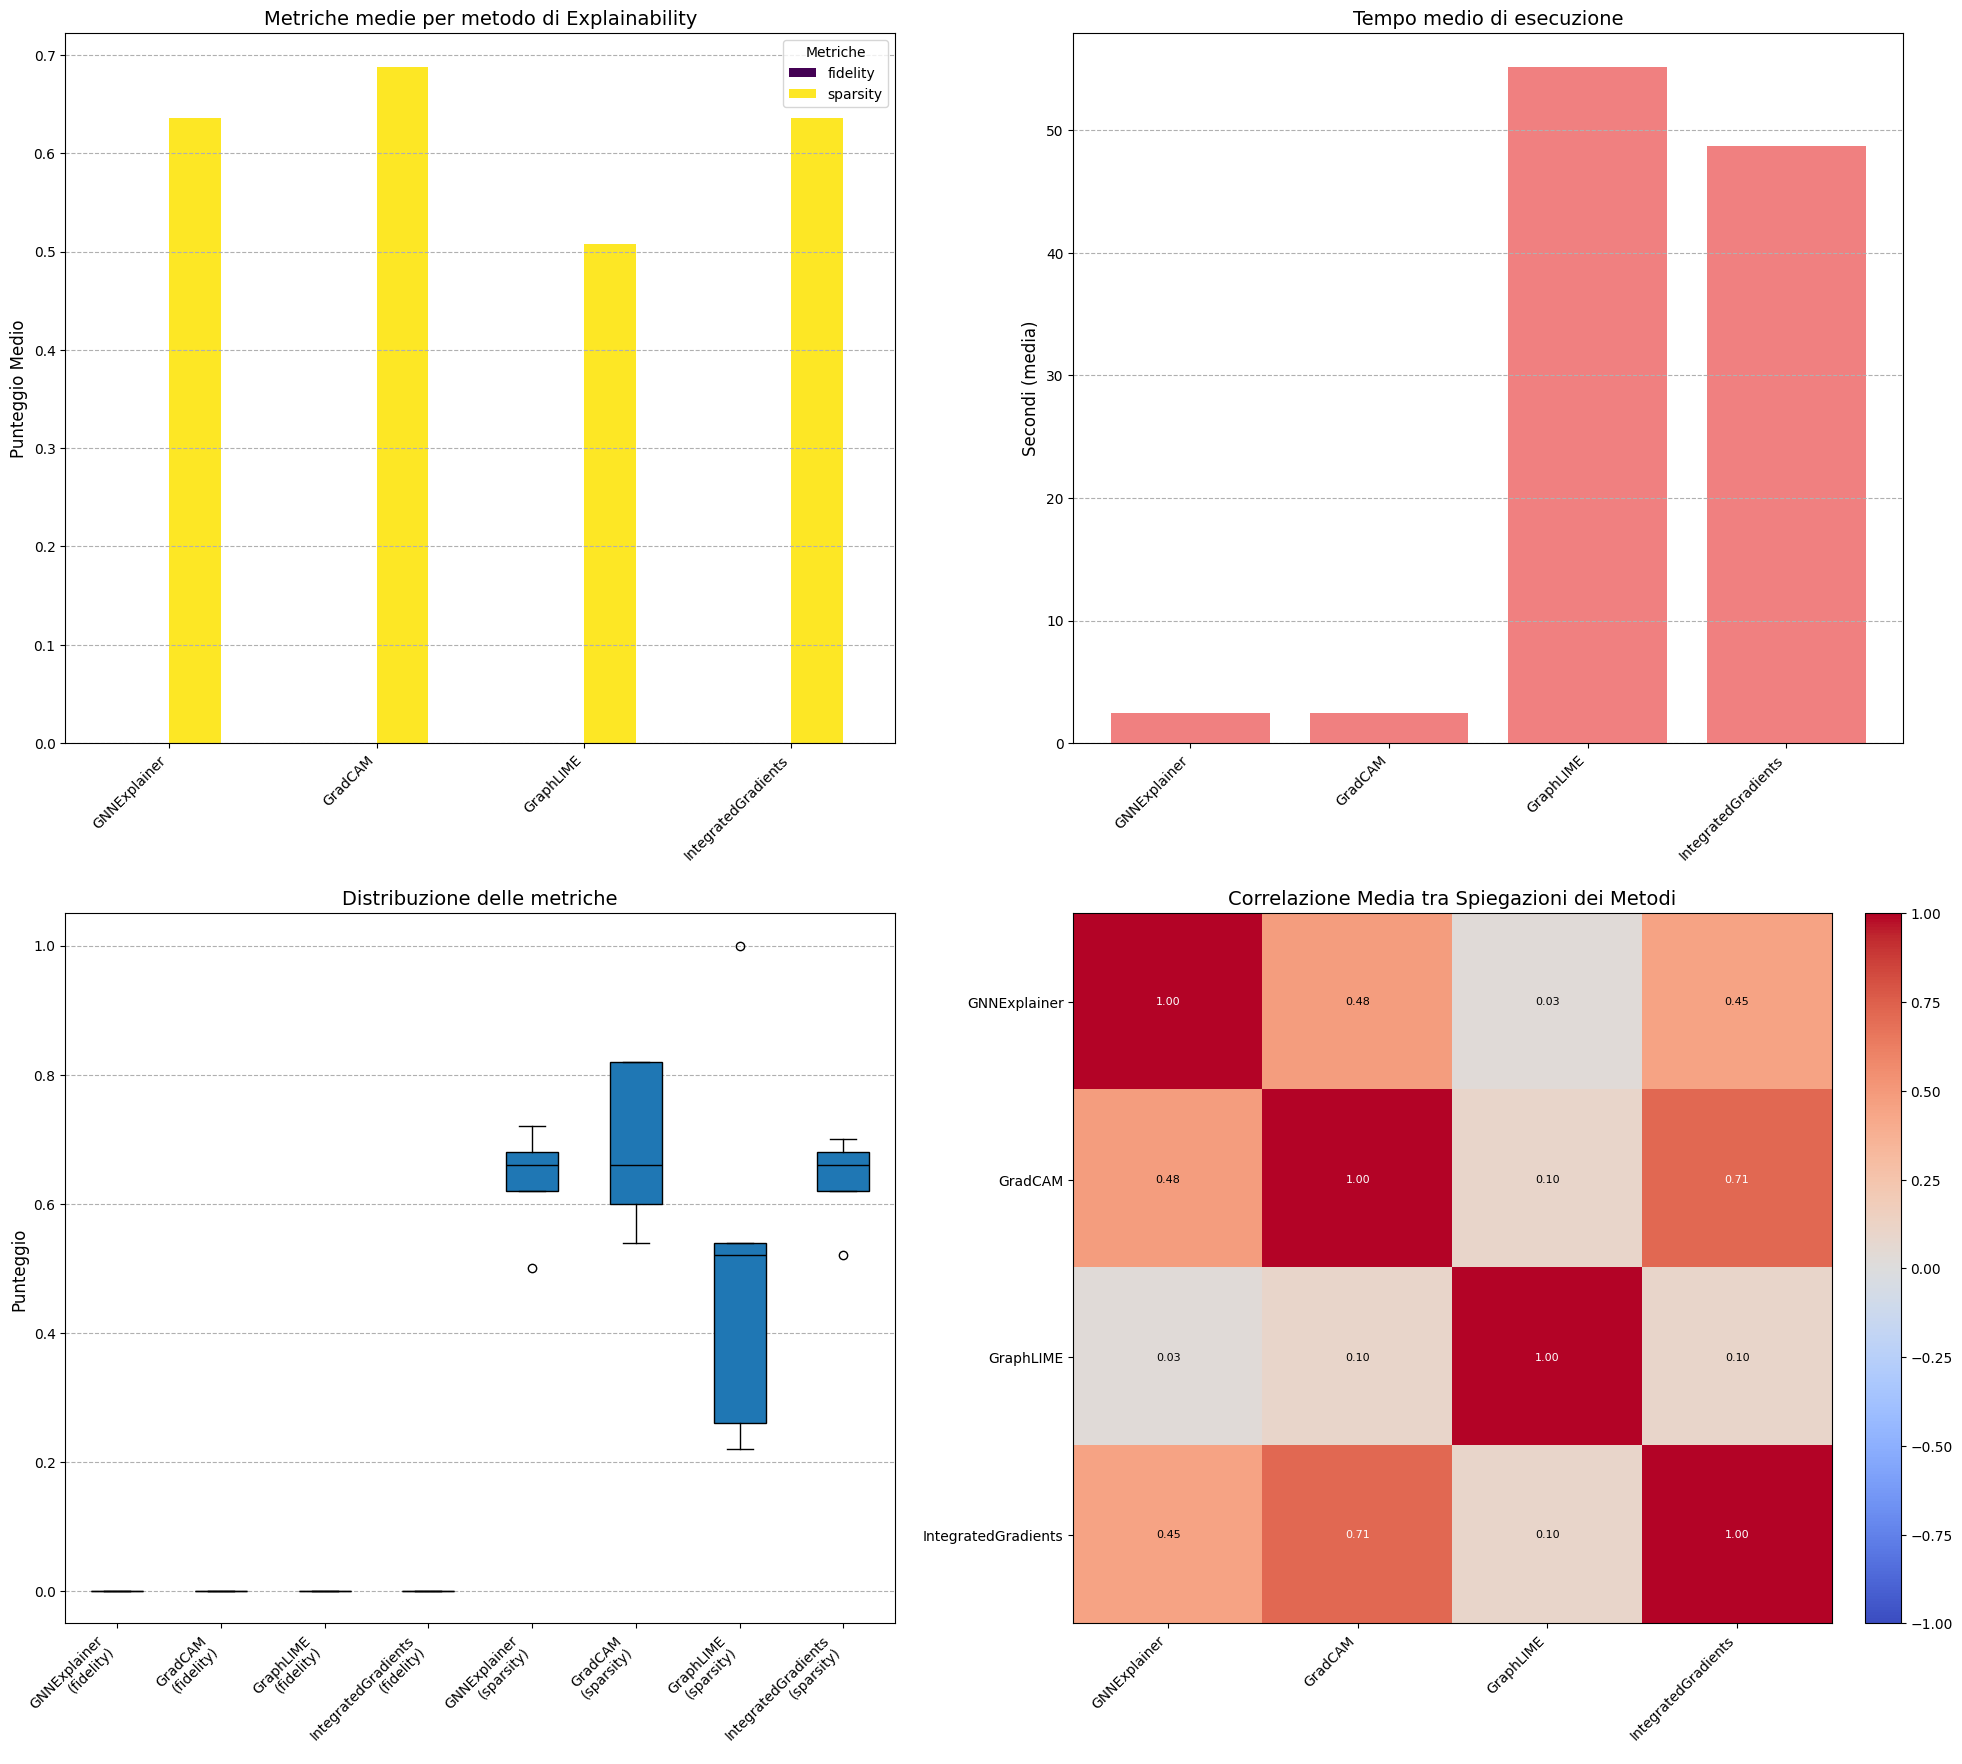

2025-05-21 02:20:49,581 - INFO - Risultati di explainability salvati in: /home/gianuca/Scrivania/Tesi/Progetto/brain-tumor-graph-segmentation-main/brain-tumor-graph-segmentation-main/reports/explainability_results.pkl


In [20]:
# ----------------------------------------------------------------------------------
# CELLA 18: Esecuzione Confronto Metodi di Explainability
# ----------------------------------------------------------------------------------
# Definisci i nodi target (es. 5 nodi casuali, o selezionali strategicamente)
if 'data' in locals() and data.x.shape[0] > 0: # Aggiunto controllo per 'data'
    num_target_nodes_eval = min(5, data.x.shape[0])
    target_nodes_for_eval = random.sample(range(data.x.shape[0]), num_target_nodes_eval) # <--- MODIFICATO (nome variabile)
else:
    logging.error("data.x è vuoto o 'data' non è definito, impossibile selezionare nodi target.")
    target_nodes_for_eval = [] # <--- MODIFICATO (nome variabile)

# Dizionario con le funzioni/metodi explainer
# Assicurati che gnn_explainer_simple, gradcam_explainer, graph_lime, integrated_gradients siano definite
explainers_functions_dict = {
    "GNNExplainer": gnn_explainer_simple,
    "GradCAM": gradcam_explainer,
    "GraphLIME": graph_lime.explain_node, 
    "IntegratedGradients": integrated_gradients.explain_node
}

logging.info(f"Avvio confronto metodi di explainability su {len(target_nodes_for_eval)} nodi...")
if target_nodes_for_eval: # Procedi solo se ci sono nodi target
    results_explainability = simplified_compare_explainers(
        model, 
        data, 
        target_nodes_for_eval, # Nome variabile corretto 
        explainers_functions_dict
    )

    # Visualizza e salva i risultati del confronto
    # Assicurati che plot_explanation_comparison sia definita (Cella 17)
    # e che reports_path sia definito (Cella 2)
    if 'plot_explanation_comparison' in locals() and 'reports_path' in locals():
        plot_explanation_comparison(results_explainability, reports_path, target_nodes_list=target_nodes_for_eval) # <--- Corretta indentazione e passato target_nodes_list
    else:
        logging.warning("Funzione 'plot_explanation_comparison' o 'reports_path' non definite. Salto il plot.")

    # Salva i risultati numerici
    if 'reports_path' in locals():
        results_pkl_path = os.path.join(reports_path, 'explainability_results.pkl')
        with open(results_pkl_path, 'wb') as f:
            pickle.dump(results_explainability, f)
        logging.info(f"Risultati di explainability salvati in: {results_pkl_path}")
    else:
        logging.warning("'reports_path' non definito. Impossibile salvare i risultati .pkl.")
else:
    logging.warning("Nessun nodo target per il confronto degli explainer.")
    results_explainability = {} # Dizionario vuoto se non ci sono nodi

## **Funzioni per generare spiegazioni con LLM**

In [21]:
# ----------------------------------------------------------------------------------
# CELLA 18.1: Definizione Descrizioni Feature e Nomi Classi per LLM
# ----------------------------------------------------------------------------------

# !!! IMPORTANTE: Popola questo dizionario con le descrizioni reali delle tue 50 feature !!!
# Esempio con placeholder per 50 feature
node_feature_descriptions_llm = {i: f"Descrizione Feature {i+1}" for i in range(num_node_features)} # num_node_features è 50 dalla Cella 4

# Se hai nomi specifici, usali. Esempio:
# node_feature_descriptions_llm = {
#     0: "Intensità Media T1",
#     1: "Varianza Intensità T1c",
#     2: "GLCM Entropia Flair",
#     # ... fino a 49
# }
logging.info(f"Definita node_feature_descriptions_llm con {len(node_feature_descriptions_llm)} features.")

# Nomi delle classi (assicurati che l'ordine corrisponda agli indici 0, 1, 2, 3 usati dal modello)
class_names_map_llm = {
    0: "Non-tumore",
    1: "NCR (Necrotic Tumor Core)",
    2: "ED (Peritumoral Edema)",
    3: "ET (Enhancing Tumor)"
}
logging.info(f"Definita class_names_map_llm: {class_names_map_llm}")

# Controlla che le variabili siano ora definite per la cella di debug successiva (Cella 23)
if 'node_feature_descriptions_llm' in locals():
    print(f"CELLA 18.1: node_feature_descriptions_llm definita. Esempio: {list(node_feature_descriptions_llm.items())[:2]}")
if 'class_names_map_llm' in locals():
    print(f"CELLA 18.1: class_names_map_llm definita. Contenuto: {class_names_map_llm}")

2025-05-21 02:29:48,936 - INFO - Definita node_feature_descriptions_llm con 50 features.
2025-05-21 02:29:48,937 - INFO - Definita class_names_map_llm: {0: 'Non-tumore', 1: 'NCR (Necrotic Tumor Core)', 2: 'ED (Peritumoral Edema)', 3: 'ET (Enhancing Tumor)'}


CELLA 18.1: node_feature_descriptions_llm definita. Esempio: [(0, 'Descrizione Feature 1'), (1, 'Descrizione Feature 2')]
CELLA 18.1: class_names_map_llm definita. Contenuto: {0: 'Non-tumore', 1: 'NCR (Necrotic Tumor Core)', 2: 'ED (Peritumoral Edema)', 3: 'ET (Enhancing Tumor)'}


In [22]:
# Ottimizzata Cella 19
# (Assumiamo che node_feature_descriptions sia definito come in Cella 39
# e passato come argomento)
# (Assumiamo che initial_outputs, initial_predicted_labels siano disponibili globalmente o passati)

def prepare_explanation_data_for_llm(
    results,
    target_nodes,
    model_outputs, # Passa qui gli output originali del modello GNN sui dati
    node_feature_descriptions,
    class_names=None
):
    """
    Prepara i dati dalle spiegazioni per l'analisi con LLM, arricchendoli.
    
    Args:
        results: Risultati delle valutazioni degli explainer.
        target_nodes: Lista di nodi target analizzati.
        model_outputs: Tensor degli output del modello GNN (logits o probabilità).
        node_feature_descriptions: Dizionario con descrizioni semantiche delle feature.
        class_names: Nomi delle classi.
        
    Returns:
        list: Lista di dizionari, uno per ogni nodo target, pronti per l'LLM.
    """
    if class_names is None:
        class_names = ["Non-tumore", "NCR (Necrotic Tumor Core)", 
                       "ED (Peritumoral Edema)", "ET (Enhancing Tumor)"]
    
    explanation_contexts = []
    
    # Calcola le probabilità di confidenza una volta
    confidences_per_class = torch.softmax(model_outputs, dim=1)

    for node_idx in target_nodes:
        node_context = {"node_id": int(node_idx)}
        
        # Informazioni sulla predizione del modello GNN principale
        main_pred_class_idx = model_outputs[node_idx].argmax().item()
        node_context["main_model_prediction"] = {
            "predicted_class_name": class_names[main_pred_class_idx],
            "predicted_class_index": main_pred_class_idx,
            "confidence": confidences_per_class[node_idx, main_pred_class_idx].item(),
            "all_class_confidences": {
                name: confidences_per_class[node_idx, i].item() for i, name in enumerate(class_names)
            }
        }

        # Informazioni da ogni explainer
        node_context["explainers_summary"] = []
        for explainer_name, explainer_results in results["explanations"].items():
            if node_idx not in explainer_results:
                continue

            feature_importance = explainer_results[node_idx]
            pred_class_by_explainer_idx = results["predicted_classes"][explainer_name][node_idx] # Assumiamo che questa sia la classe per cui la spiegazione è generata
            
            if isinstance(feature_importance, np.ndarray):
                feature_importance = torch.tensor(feature_importance, dtype=torch.float32) # Assicura che sia un tensore float
            
            feature_importance_abs = feature_importance.abs()
            num_top_features = min(5, feature_importance_abs.shape[0])
            
            # Gestione per feature_importance_abs vuoto o con tutti zeri
            if feature_importance_abs.numel() == 0 or feature_importance_abs.max() == 0:
                top_values, top_indices = torch.tensor([]), torch.tensor([])
                global_mean, global_std = 0.0, 0.0
            else:
                top_values, top_indices = torch.topk(feature_importance_abs, k=num_top_features)
                global_mean = feature_importance_abs.mean().item()
                global_std = feature_importance_abs.std().item()

            explainer_summary = {
                "method_name": explainer_name,
                "target_class_for_explanation": class_names[pred_class_by_explainer_idx], # Classe spiegata
                "top_features": [
                    {
                        "feature_index": int(idx.item()),
                        "feature_description": node_feature_descriptions.get(int(idx.item()), f"Feature {int(idx.item())}"),
                        "importance_score": float(top_values[i].item()),
                        "z_score": float((top_values[i].item() - global_mean) / (global_std + 1e-8)) if global_std > 1e-8 else 0.0
                    }
                    for i, idx in enumerate(top_indices)
                ],
                "metrics": {
                    "fidelity": results["fidelity"][explainer_name][target_nodes.index(node_idx)],
                    "sparsity": results["sparsity"][explainer_name][target_nodes.index(node_idx)],
                    "execution_time_sec": results["execution_time"][explainer_name][target_nodes.index(node_idx)],
                    "agrees_with_main_prediction": pred_class_by_explainer_idx == main_pred_class_idx
                }
            }
            node_context["explainers_summary"].append(explainer_summary)
        
        explanation_contexts.append(node_context)
    
    return explanation_contexts

In [23]:
# Ottimizzata Cella 20
import requests
import json
import logging # Importa il modulo logging

# Configura il logging di base (puoi farlo all'inizio del notebook)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Valori di default, potrebbero essere letti da _config o passati come argomenti
DEFAULT_LLM_URL = "http://127.0.0.1:1234/v1/chat/completions"
DEFAULT_LLM_MODEL = "llama-3.2-3b-instruct" # Modello esempio, assicurati sia quello corretto per LM Studio
DEFAULT_SYSTEM_PROMPT = "Sei un radiologo esperto che analizza i risultati di un modello GNN per la segmentazione di tumori cerebrali. Il tuo compito è interpretare le spiegazioni fornite dai metodi di explainability (come GNNExplainer, GradCAM, etc.) e tradurle in un linguaggio chiaro e clinicamente rilevante. Evidenzia le feature più importanti, confronta i metodi se i dati lo permettono, e discuti le implicazioni per la pratica clinica, inclusa la fiducia nella predizione del modello GNN per il supervoxel analizzato."

def get_llm_completion(
    user_prompt,
    system_prompt=DEFAULT_SYSTEM_PROMPT,
    llm_url=DEFAULT_LLM_URL,
    model_name=DEFAULT_LLM_MODEL,
    temperature=0.7,
    timeout_seconds=3600 # Ridotto a 3 minuti, aggiustare se necessario
):
    """
    Invia il prompt utente a un endpoint LLM e restituisce la completazione.
    """
    try:
        headers = {"Content-Type": "application/json"}
        payload = {
            "model": model_name,
            "messages": [
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt}
            ],
            "temperature": temperature,
            "stream": False # Mantenuto False per semplicità, True per risposte incrementali
        }
        
        logging.info(f"Invio richiesta all'LLM: {llm_url} con modello {model_name}")
        response = requests.post(llm_url, headers=headers, json=payload, timeout=timeout_seconds)
        response.raise_for_status()  # Solleva eccezione per errori HTTP
        
        result = response.json()
        logging.debug(f"Risposta grezza dall'LLM: {result}") # Usa logging.debug per output verboso
        
        if "choices" in result and len(result["choices"]) > 0 and "message" in result["choices"][0] and "content" in result["choices"][0]["message"]:
            completion_text = result["choices"][0]["message"]["content"]
            logging.info("Risposta LLM ricevuta con successo.")
            return completion_text
        else:
            logging.warning(f"Formato risposta LLM inatteso: {result}")
            return None
            
    except requests.exceptions.Timeout:
        logging.error(f"Timeout durante la richiesta all'LLM ({timeout_seconds}s).")
        return None
    except requests.exceptions.RequestException as e:
        logging.error(f"Errore di rete durante la richiesta all'LLM: {e}")
        return None
    except json.JSONDecodeError as e:
        logging.error(f"Errore nel decodificare la risposta JSON dall'LLM: {e}")
        return None
    except Exception as e:
        logging.error(f"Errore generico durante la chiamata all'LLM: {e}")
        return None

In [24]:
# Rinominata e Ottimizzata Cella 21
def generate_prompt_for_llm_and_get_explanation(
    node_data_for_llm, # Output di prepare_explanation_data_for_llm per un singolo nodo
    subject_id_str, # Passa l'ID del soggetto per contesto
    custom_system_prompt=None # Permette di sovrascrivere il prompt di sistema
):
    """
    Costruisce un prompt dettagliato per un singolo nodo e ottiene la spiegazione dall'LLM.
    """
    
    # --- Costruzione del Prompt per l'Utente (user_prompt) ---
    user_prompt = f"Analisi del supervoxel ID {node_data_for_llm['node_id']} per il soggetto {subject_id_str}.\n\n"
    user_prompt += "Predizione del Modello GNN Principale:\n"
    user_prompt += f"- Classe Predetta: {node_data_for_llm['main_model_prediction']['predicted_class_name']}\n"
    user_prompt += f"- Confidenza: {node_data_for_llm['main_model_prediction']['confidence']:.2f}\n"
    user_prompt += "- Confidenze per tutte le classi:\n"
    for cls_name, conf in node_data_for_llm['main_model_prediction']['all_class_confidences'].items():
        user_prompt += f"  - {cls_name}: {conf:.2f}\n"
    user_prompt += "\n"

    user_prompt += "Analisi dei Metodi di Explainability:\n"
    if not node_data_for_llm['explainers_summary']:
        user_prompt += "Nessun dato di explainability disponibile per questo nodo.\n"
    
    for explainer_info in node_data_for_llm['explainers_summary']:
        user_prompt += f"\n--- Metodo: {explainer_info['method_name']} (spiegazione per classe: {explainer_info['target_class_for_explanation']}) ---\n"
        user_prompt += "Feature più importanti:\n"
        if explainer_info['top_features']:
            for feat in explainer_info['top_features']:
                user_prompt += f"- {feat['feature_description']} (Indice: {feat['feature_index']}): Importanza {feat['importance_score']:.3f}, Z-score {feat['z_score']:.2f}\n"
        else:
            user_prompt += "Nessuna feature importante identificata o importanza nulla.\n"
            
        user_prompt += "Metriche di Explainability:\n"
        user_prompt += f"- Fedeltà: {explainer_info['metrics']['fidelity']:.3f}\n"
        user_prompt += f"- Sparsità: {explainer_info['metrics']['sparsity']:.3f}\n"
        user_prompt += f"- Tempo di esecuzione: {explainer_info['metrics']['execution_time_sec']:.2f}s\n"
        user_prompt += f"- Concordanza con predizione principale: {'Sì' if explainer_info['metrics']['agrees_with_main_prediction'] else 'No'}\n"

    user_prompt += "\n--- Richiesta di Analisi al Radiologo Esperto (LLM) ---\n"
    user_prompt += "Basandoti sulle informazioni fornite sopra:\n"
    user_prompt += "1. Fornisci una valutazione sintetica della predizione del GNN per questo supervoxel. È affidabile? Quali elementi supportano o mettono in dubbio la predizione?\n"
    user_prompt += "2. Interpreta le feature più importanti (in particolare quelle di GNNExplainer, se disponibili e concordanti) dal punto di vista di un radiologo. Ad esempio, se 'Intensità T1c (mediana)' è alta e la classe è 'ET (Enhancing Tumor)', cosa implica clinicamente?\n"
    user_prompt += "3. Confronta le indicazioni dei diversi metodi di explainability. Ci sono accordi o disaccordi significativi tra loro (sia per le feature importanti sia per le metriche)?\n"
    user_prompt += "4. Quali sono le implicazioni cliniche di questa analisi per questo specifico supervoxel? Come potrebbe aiutare un medico (es. aumentare la fiducia, identificare artefatti, suggerire particolari tipi di tessuto tumorale o non tumorale)?\n"
    user_prompt += "5. Concludi con un giudizio complessivo sulla classificazione del supervoxel, considerando tutti i dati.\n\n"
    user_prompt += "Rispondi in modo strutturato, chiaro e clinicamente rilevante."

    logging.info(f"Generazione spiegazione LLM per nodo {node_data_for_llm['node_id']} del soggetto {subject_id_str}...")
    
    if custom_system_prompt:
        llm_explanation_text = get_llm_completion(user_prompt, system_prompt=custom_system_prompt)
    else:
        llm_explanation_text = get_llm_completion(user_prompt)

    if not llm_explanation_text:
        # Fallback se l'LLM non risponde
        return f"Spiegazione LLM non disponibile per il nodo {node_data_for_llm['node_id']}. Classe predetta: {node_data_for_llm['main_model_prediction']['predicted_class_name']}."
        
    return llm_explanation_text

In [25]:
# CELLA 22 (MODIFICATA COMPLETA)
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import logging

def visualize_explanation_with_llm(
    node_idx,
    results,
    explanation_text,
    node_feature_descriptions_map, # Nome del parametro per chiarezza
    reports_folder_path,         # Nome del parametro per chiarezza
    class_names_mapping=None       # Nome del parametro per chiarezza
):
    """
    Visualizza i risultati dell'explainability insieme alla spiegazione LLM.
    
    Args:
        node_idx: Indice del nodo da visualizzare
        results: Risultati delle valutazioni
        explanation_text: Testo generato dall'LLM
        node_feature_descriptions_map: Dizionario con descrizioni semantiche delle feature.
        reports_folder_path: Percorso della cartella per salvare i report/figure.
        class_names_mapping: Dizionario o lista con i nomi delle classi.
    """
    _class_names_list_for_plot = []
    if class_names_mapping is None:
        _class_names_list_for_plot = ["Non-tumore", "NCR", "ED", "ET"] # Default
    elif isinstance(class_names_mapping, dict):
        # Assumi che le chiavi siano 0, 1, 2, 3... e crea una lista ordinata
        try:
            max_idx = max(class_names_mapping.keys()) if class_names_mapping else -1
            _class_names_list_for_plot = [class_names_mapping.get(i, f"Classe {i}") for i in range(max_idx + 1)]
        except Exception as e:
            logging.warning(f"Problema nella creazione di _class_names_list_for_plot dal dizionario: {e}. Uso nomi di fallback.")
            _class_names_list_for_plot = [f"Classe {i}" for i in range(len(results.get("predicted_classes", {}).get("GNNExplainer", {}).get(node_idx, [0,0,0,0])))] # Fallback basato sul numero di classi
            if not _class_names_list_for_plot: _class_names_list_for_plot = ["Non-tumore", "NCR", "ED", "ET"]


    elif isinstance(class_names_mapping, list):
        _class_names_list_for_plot = class_names_mapping
    else:
        # Fallback se il tipo non è riconosciuto
        num_classes_fallback = 4 # Assumiamo 4 classi se non diversamente specificato
        if "outputs" in globals() and outputs is not None: # Tenta di derivare dal tensore outputs
             num_classes_fallback = outputs.shape[1]
        _class_names_list_for_plot = [f"Classe {i}" for i in range(num_classes_fallback)]


    plt.figure(figsize=(20, 12))
    
    # Parte sinistra: visualizzazione dell'importanza delle feature
    ax1 = plt.subplot(1, 2, 1)
    
    if "GNNExplainer" not in results.get("explanations", {}) or node_idx not in results["explanations"].get("GNNExplainer", {}):
        ax1.text(0.5, 0.5, f"Dati di GNNExplainer non disponibili\nper il nodo {node_idx}", 
                 horizontalalignment='center', verticalalignment='center', fontsize=12)
        ax1.set_title(f"Feature per nodo {node_idx}")
        ax1.axis('off')
    else:
        feature_importance = results["explanations"]["GNNExplainer"][node_idx]
        if isinstance(feature_importance, np.ndarray):
            feature_importance = torch.tensor(feature_importance, dtype=torch.float32)
        
        feature_importance_abs = feature_importance.abs()
        if feature_importance_abs.numel() == 0 or feature_importance_abs.max() == 0:
            feature_importance_norm = torch.zeros_like(feature_importance_abs)
        else:
            feature_importance_norm = feature_importance_abs / (feature_importance_abs.max() + 1e-8)
        
        sorted_indices = torch.argsort(feature_importance_norm, descending=True)
        top_n = min(20, len(sorted_indices))
        
        top_indices = sorted_indices[:top_n]
        top_values = feature_importance_norm[top_indices]
        
        ax1.bar(range(top_n), top_values.cpu().numpy())
        ax1.set_xticks(range(top_n))
        
        feature_labels = []
        for idx_val_tensor in top_indices: # Itera direttamente sui tensori
            idx_val = idx_val_tensor.item() # Converti a intero Python
            feature_labels.append(node_feature_descriptions_map.get(idx_val, f"F{idx_val}"))

        ax1.set_xticklabels(feature_labels, rotation=90, ha='right')
        ax1.set_title(f"Top {top_n} Feature Importanti (GNNExplainer) per Nodo {node_idx}")
        ax1.set_xlabel("Feature")
        ax1.set_ylabel("Importanza Normalizzata")
        
        pred_class_idx = results["predicted_classes"]["GNNExplainer"][node_idx]
        # Assicurarsi che model e data siano disponibili globalmente o passati come argomenti
        try:
            if 'model' in globals() and 'data' in globals():
                with torch.no_grad():
                    # Assicurati che data.edge_index sia del tipo corretto
                    edge_index_for_model = data.edge_index.type(torch.long if data.edge_index.dtype != torch.long else data.edge_index.dtype)
                    model_prediction_outputs = model(data.x, edge_index_for_model)
                    confidence = torch.softmax(model_prediction_outputs, dim=1)[node_idx, pred_class_idx].item()
                # Usa _class_names_list_for_plot che è sicuramente una lista
                ax1.set_xlabel(f"Feature (Classe predetta: {_class_names_list_for_plot[pred_class_idx]}, Conf: {confidence:.2f})")
            else:
                ax1.set_xlabel(f"Feature (Classe predetta: {_class_names_list_for_plot[pred_class_idx]})")
        except Exception as e:
            logging.warning(f"Errore durante il calcolo della confidenza per il plot (nodo {node_idx}): {e}")
            ax1.set_xlabel(f"Feature (Classe predetta: {_class_names_list_for_plot[pred_class_idx]})")

    # Parte destra: testo LLM
    ax2 = plt.subplot(1, 2, 2)
    ax2.axis('off')
    ax2.text(0.01, 0.98, "Spiegazione generata dall'LLM:", fontsize=14, fontweight='bold', va='top')
    ax2.text(0.01, 0.90, explanation_text, fontsize=10, wrap=True, va='top', 
             bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', alpha=0.9))

    plt.suptitle(f"Analisi di Spiegabilità per il Nodo {node_idx}", fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    try:
        # Usa reports_folder_path passato come argomento
        if not os.path.isdir(reports_folder_path):
            os.makedirs(reports_folder_path, exist_ok=True)
            logging.info(f"Creata cartella reports: {reports_folder_path}")

        figure_path = os.path.join(reports_folder_path, f'node_{node_idx}_llm_explanation.png')
        plt.savefig(figure_path, dpi=300, bbox_inches='tight')
        logging.info(f"Visualizzazione salvata in: {figure_path}")
    except Exception as e:
        logging.error(f"Errore durante il salvataggio della figura in {reports_folder_path}: {e}")
        
    plt.show()

## **Generazione e visualizzazione delle spiegazioni LLM**

In [26]:
# CELLA di DEBUG
print("Controllo variabili richieste per LLM explainability:")
print(f"- 'results_explainability' definita: {'Sì' if 'results_explainability' in locals() else 'No'}")
if 'results_explainability' in locals():
    print(f"  └── Non vuota: {'Sì' if results_explainability else 'No'}")

print(f"- 'target_nodes_for_eval' definita: {'Sì' if 'target_nodes_for_eval' in locals() else 'No'}")
if 'target_nodes_for_eval' in locals():
    print(f"  └── Numero di nodi: {len(target_nodes_for_eval) if target_nodes_for_eval else 0}")

print(f"- 'outputs' definita: {'Sì' if 'outputs' in locals() else 'No'}")
if 'outputs' in locals():
    print(f"  └── Forma del tensore: {outputs.shape if outputs is not None else 'None'}")

print(f"- 'node_feature_descriptions_llm' definita: {'Sì' if 'node_feature_descriptions_llm' in locals() else 'No'}")
print(f"- 'class_names_map_llm' definita: {'Sì' if 'class_names_map_llm' in locals() else 'No'}")

Controllo variabili richieste per LLM explainability:
- 'results_explainability' definita: Sì
  └── Non vuota: Sì
- 'target_nodes_for_eval' definita: Sì
  └── Numero di nodi: 5
- 'outputs' definita: Sì
  └── Forma del tensore: torch.Size([2607, 4])
- 'node_feature_descriptions_llm' definita: Sì
- 'class_names_map_llm' definita: Sì


2025-05-21 02:31:37,309 - INFO - Preparazione dati contestuali per LLM...
2025-05-21 02:31:37,315 - INFO - Processando nodo 1/2 con LLM: ID 974
2025-05-21 02:31:37,316 - INFO - Generazione spiegazione LLM per nodo 974 del soggetto BraTS-GLI-01166-000...
2025-05-21 02:31:37,316 - INFO - Invio richiesta all'LLM: http://127.0.0.1:1234/v1/chat/completions con modello llama-3.2-3b-instruct
2025-05-21 02:33:33,996 - INFO - Risposta LLM ricevuta con successo.
2025-05-21 02:33:33,997 - INFO - Processando nodo 2/2 con LLM: ID 2427
2025-05-21 02:33:33,997 - INFO - Generazione spiegazione LLM per nodo 2427 del soggetto BraTS-GLI-01166-000...
2025-05-21 02:33:33,998 - INFO - Invio richiesta all'LLM: http://127.0.0.1:1234/v1/chat/completions con modello llama-3.2-3b-instruct
2025-05-21 02:35:57,906 - INFO - Risposta LLM ricevuta con successo.
2025-05-21 02:35:57,909 - INFO - Spiegazioni LLM dettagliate salvate in: /home/gianuca/Scrivania/Tesi/Progetto/brain-tumor-graph-segmentation-main/brain-tumor

--- Spiegazione LLM per nodo 974 ---
**Valutazione sintetica della predizione del GNN**

La predizione del modello GNN principale per il supervoxel ID 974 è classificata con una classe "Non-tumore" con una confidenza di 1,00, il che indica un'alta fiducia nella predizione. Tuttavia, non ci sono elementi che mettono in dubbio la predizione, poiché tutte le classi hanno confidenze molto basse (0,00) tranne per quella "Non-tumore", che è stata classificata con una confidenza di 1,00.

**Interpretazione delle feature più importanti**

Le feature più importanti per la spiegazione del metodo GNNExplainer sono:

* Descrizione Feature 13 (Indice: 12): Importanza 49.124, Z-score 4.09
* Descrizione Feature 14 (Indice: 13): Importanza 46.336, Z-score 3.82
* Descrizione Feature 12 (Indice: 11): Importanza 27.393, Z-score 2.02

Queste feature sono probabilmente correlate a caratteristiche del tessuto cerebrale o tumorale che sono rilevanti per la classificazione come "Non-tumore". Ad esempio, l'int

2025-05-21 02:36:04,360 - INFO - Visualizzazione salvata in: /home/gianuca/Scrivania/Tesi/Progetto/brain-tumor-graph-segmentation-main/brain-tumor-graph-segmentation-main/reports/node_974_llm_explanation.png


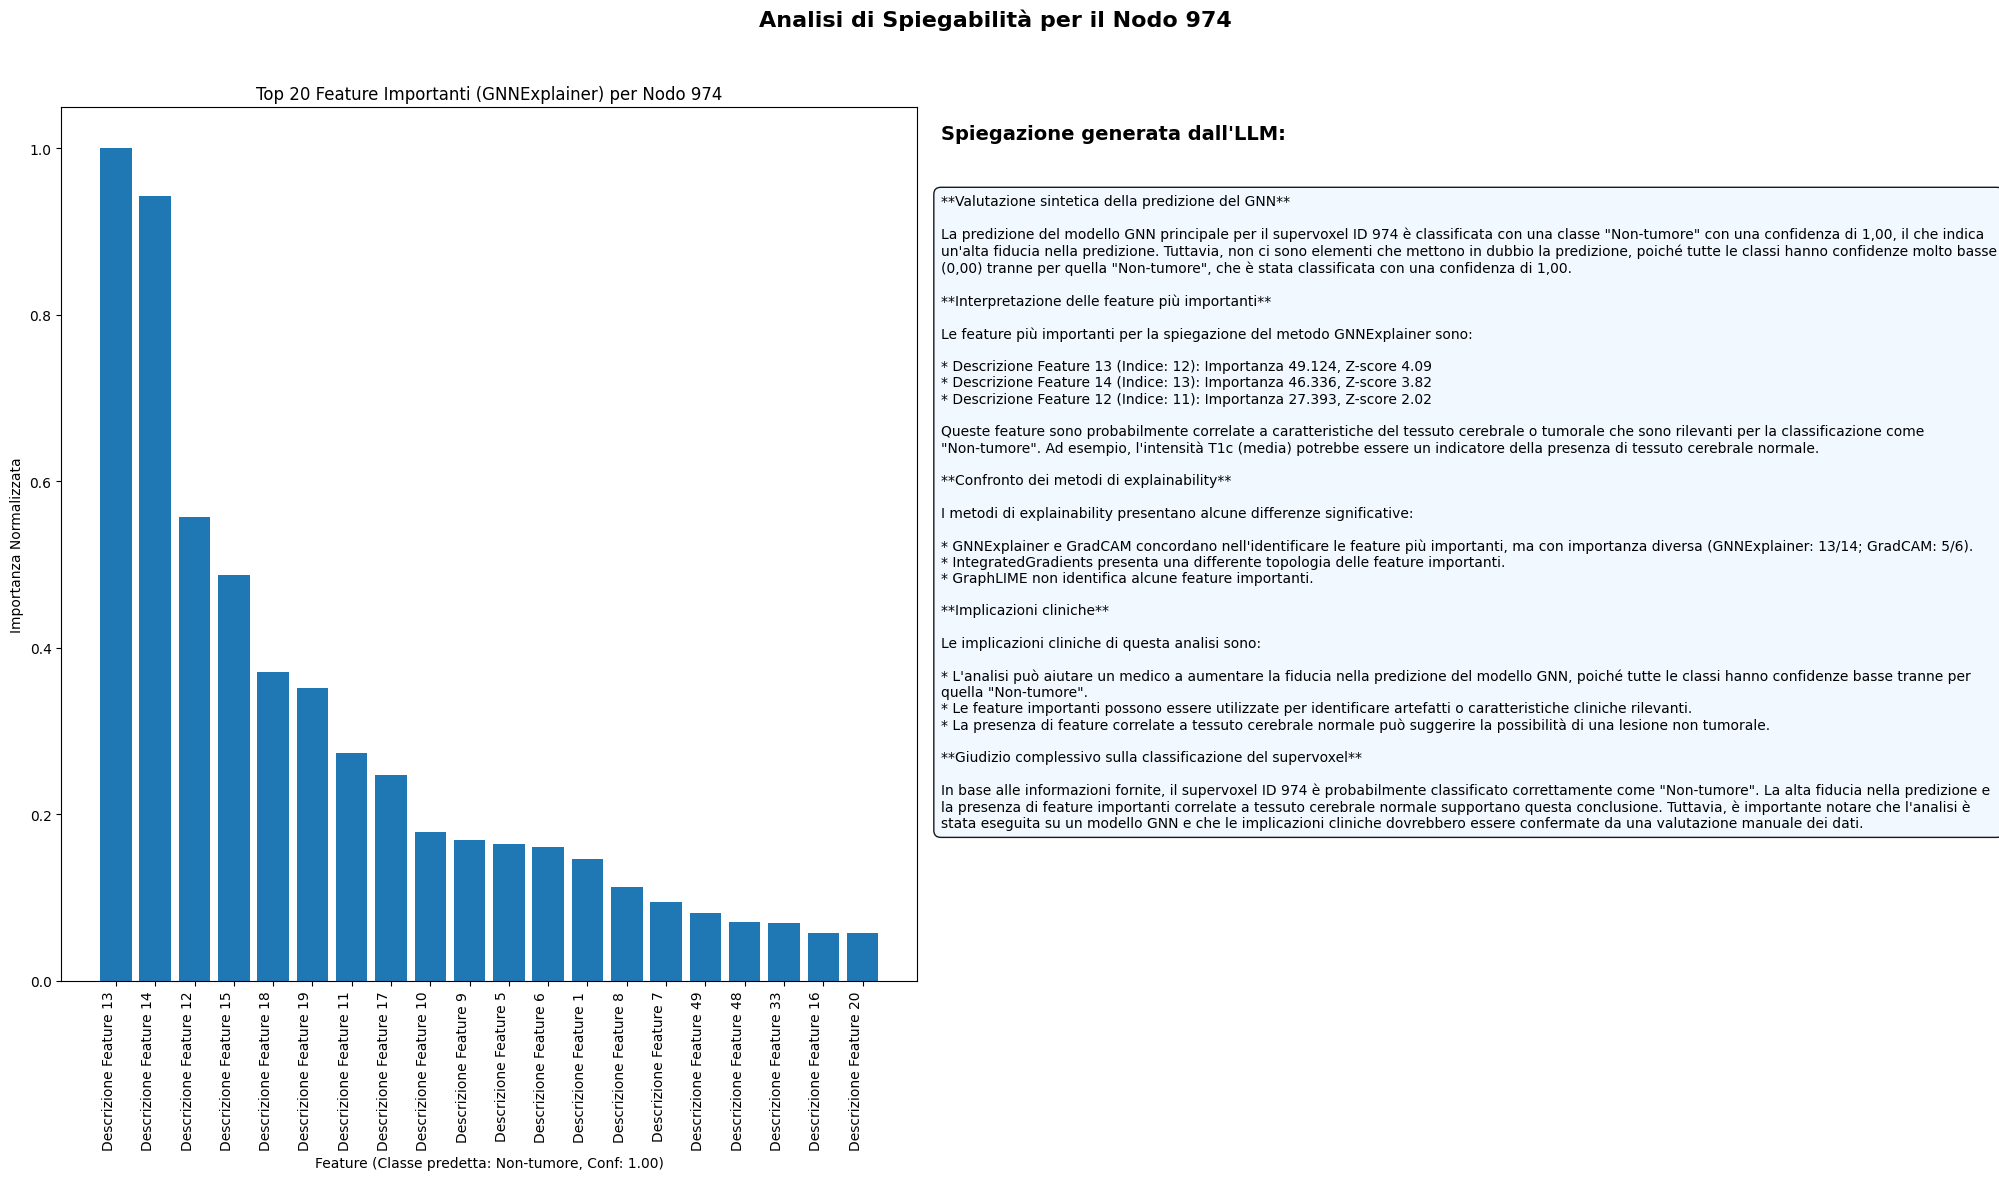

2025-05-21 02:36:07,089 - INFO - 
Visualizzazione LLM+XAI per nodo 2427


--- Spiegazione LLM per nodo 2427 ---
**Valutazione della Predizione del GNN**

La predizione del modello GNN principale per il supervoxel ID 2427 è "Non-tumore" con confidenza pari a 1.00. Ciò suggerisce che il modello ha una certezza totale sulla classificazione di questo supervoxel come non tumorale.

Tuttavia, è importante notare che la sola confidenza non è un indicatore sufficiente per valutare l'affidabilità della predizione. La comparazione con i risultati dei metodi di explainability può aiutare a comprendere meglio le ragioni alla base della classificazione.

**Interpretazione delle Feature più Importanti**

Le feature più importanti per la spiegazione del metodo GNNExplainer sono:

* Descrizione Feature 13 (Indice: 12): Importanza 90.366, Z-score 3.84
* Descrizione Feature 14 (Indice: 13): Importanza 86.343, Z-score 3.64
* Descrizione Feature 12 (Indice: 11): Importanza 50.288, Z-score 1.85

Queste feature sono associate al supervoxel ID 2427 e possono essere interpretate co

2025-05-21 02:36:15,137 - INFO - Visualizzazione salvata in: /home/gianuca/Scrivania/Tesi/Progetto/brain-tumor-graph-segmentation-main/brain-tumor-graph-segmentation-main/reports/node_2427_llm_explanation.png


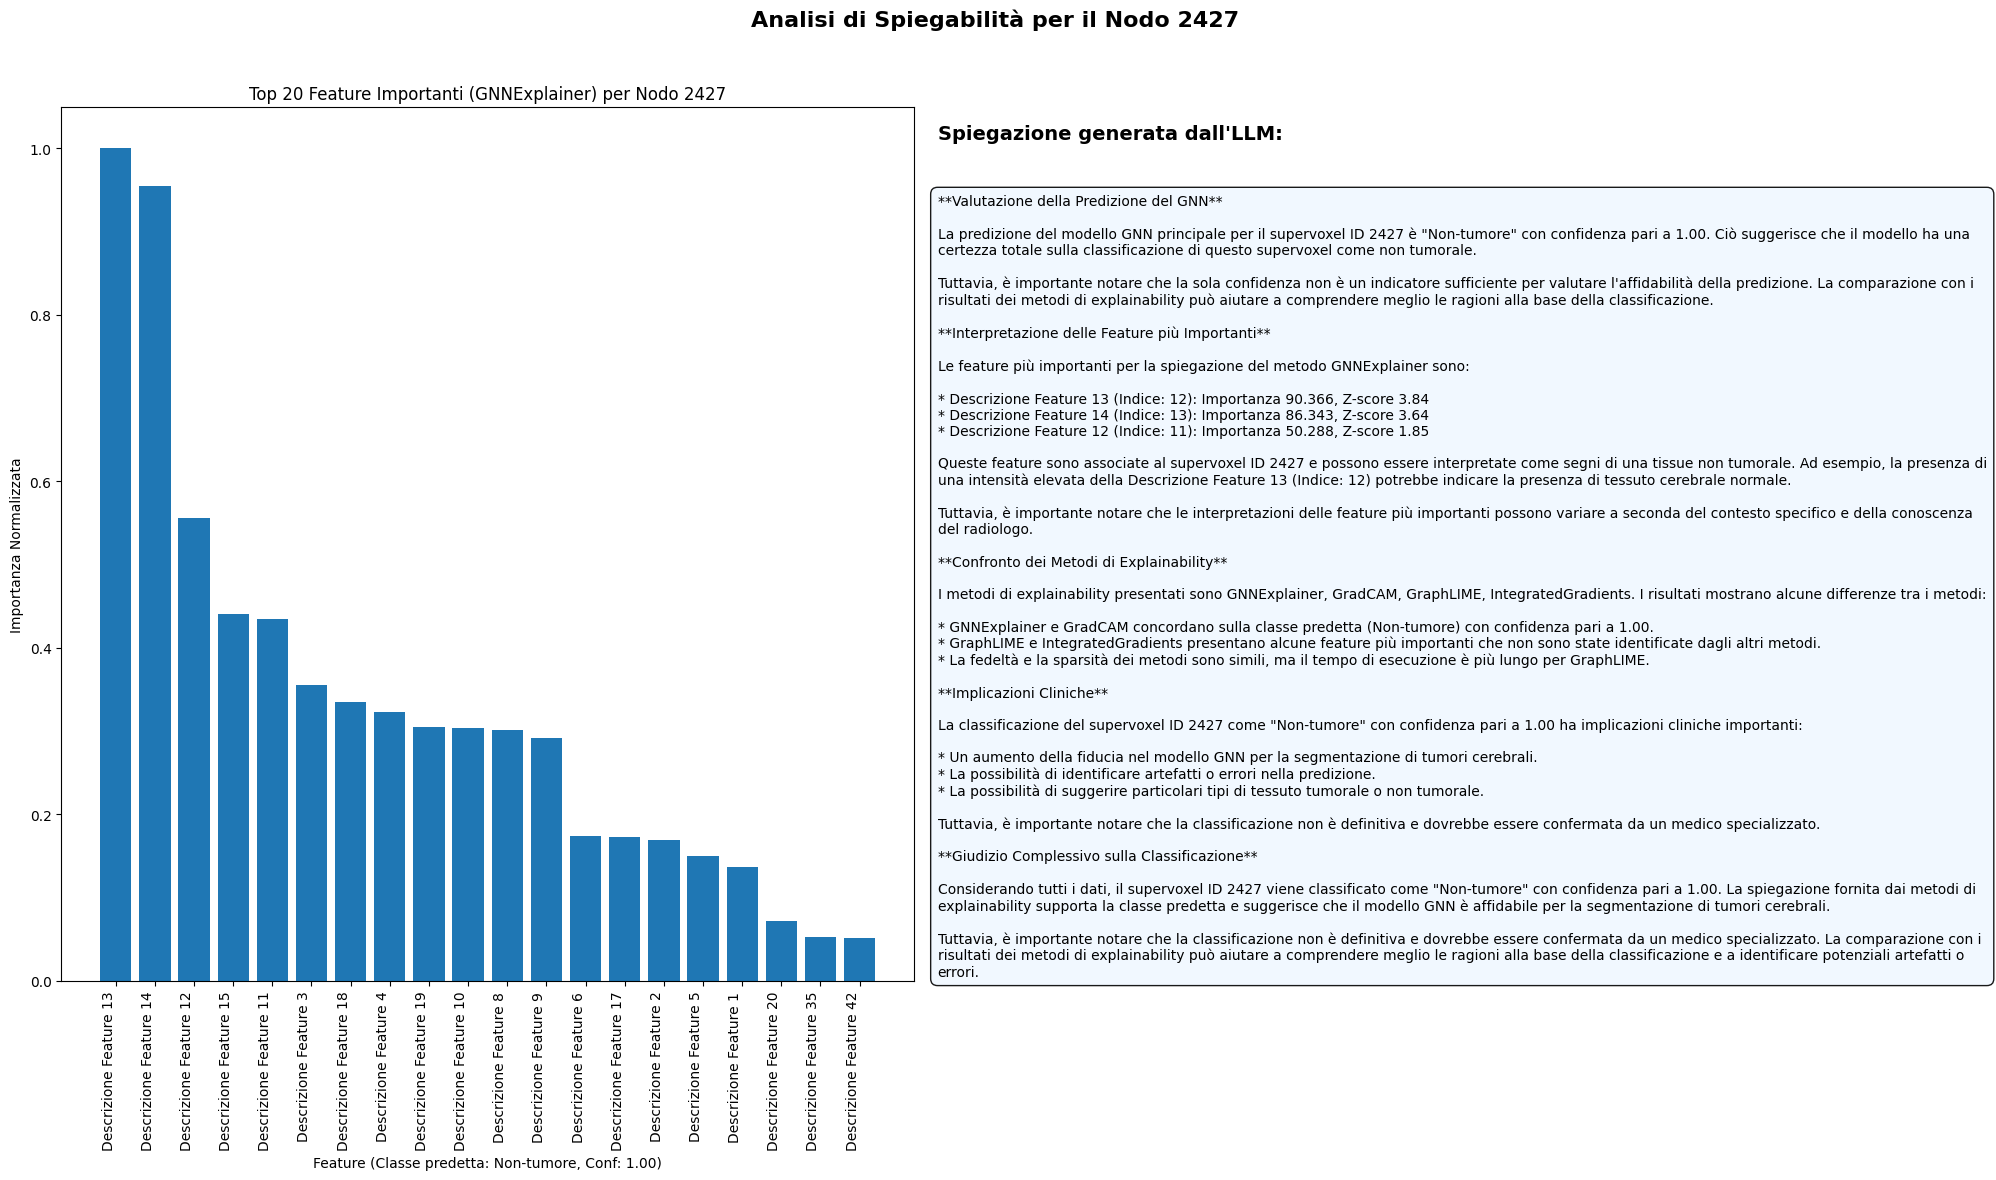

In [30]:
# CELLA 24: Flusso Principale per Generazione e Visualizzazione LLM

# Assicurati che le seguenti variabili siano definite dalle celle precedenti:
# model, data, subject_id, reports_path (globale, usato in Cella 22 modificata)
# results_explainability (da CELLA 18)
# target_nodes_for_eval (da CELLA 18, rinominato)
# outputs (i logits del modello, dalla CELLA 10)
# node_feature_descriptions_llm (dalla NUOVA CELLA 18.1)
# class_names_map_llm (dalla NUOVA CELLA 18.1)
# Le funzioni: prepare_explanation_data_for_llm (Cella 19), 
#              generate_prompt_for_llm_and_get_explanation (Cella 21), 
#              visualize_explanation_with_llm (Cella 22 modificata)

if 'results_explainability' in locals() and results_explainability and \
   'target_nodes_for_eval' in locals() and target_nodes_for_eval and \
   'outputs' in locals() and outputs is not None and \
   'node_feature_descriptions_llm' in locals() and node_feature_descriptions_llm and \
   'class_names_map_llm' in locals() and class_names_map_llm:

    logging.info("Preparazione dati contestuali per LLM...")
    explanation_contexts_for_llm = prepare_explanation_data_for_llm(
        results_explainability,                   
        target_nodes_for_eval, # Nome corretto         
        outputs,    
        node_feature_descriptions_llm, # Nome corretto
        class_names_map_llm          # Nome corretto
    )

    llm_explanations_generated_list = []
    # Limita il numero di nodi per l'analisi LLM se necessario
    # Assicurati che i nodi selezionati siano validi per 'outputs' e 'results_explainability'
    nodes_for_llm_processing = [
        node for node in target_nodes_for_eval[:min(2, len(target_nodes_for_eval))]
        if node < outputs.shape[0] and node in results_explainability.get("explanations", {}).get("GNNExplainer", {})
    ]
    
    if not nodes_for_llm_processing and target_nodes_for_eval: # Se la selezione ha fallito ma c'erano nodi target
        logging.warning(f"Nessuno dei primi nodi scelti ({target_nodes_for_eval[:min(2, len(target_nodes_for_eval))]}) è valido per LLM. Controllo dati.")
        # Fallback a un nodo valido se esiste, per test
        valid_initial_nodes = [n for n in target_nodes_for_eval if n < outputs.shape[0] and n in results_explainability.get("explanations", {}).get("GNNExplainer", {})]
        if valid_initial_nodes:
            nodes_for_llm_processing = valid_initial_nodes[:min(2, len(valid_initial_nodes))]
            logging.info(f"Usando nodi di fallback per LLM: {nodes_for_llm_processing}")


    contexts_to_process_llm = [ctx for ctx in explanation_contexts_for_llm if ctx['node_id'] in nodes_for_llm_processing]

    for i, node_ctx_for_llm in enumerate(contexts_to_process_llm):
        logging.info(f"Processando nodo {i+1}/{len(contexts_to_process_llm)} con LLM: ID {node_ctx_for_llm['node_id']}")
        # Usa generate_prompt_for_llm_and_get_explanation (dalla Cella 21)
        llm_output = generate_prompt_for_llm_and_get_explanation( 
            node_ctx_for_llm, 
            str(subject_id), 
        )
        # La funzione restituisce una tupla (text,) se successo, o stringa di fallback
        explanation_llm_text_for_node = llm_output[0] if isinstance(llm_output, tuple) else llm_output
        llm_explanations_generated_list.append(explanation_llm_text_for_node)

    # Salva le spiegazioni LLM
    if llm_explanations_generated_list:
        llm_output_json_path = os.path.join(reports_path, f'{str(subject_id)}_llm_node_explanations.json')
        llm_data_to_save = { 
            "subject_id": str(subject_id),
            "node_explanations": [
                {"node_id": ctx["node_id"], 
                 "llm_explanation_text": expl, 
                 "context_provided_to_llm": ctx} 
                for ctx, expl in zip(contexts_to_process_llm, llm_explanations_generated_list)
            ]
        }
        with open(llm_output_json_path, 'w', encoding='utf-8') as f_out_json:
            json.dump(llm_data_to_save, f_out_json, indent=2, ensure_ascii=False)
        logging.info(f"Spiegazioni LLM dettagliate salvate in: {llm_output_json_path}")

    # Visualizza le spiegazioni generate per i nodi processati
    for i, node_id_viz_llm in enumerate(nodes_for_llm_processing):
        if i < len(llm_explanations_generated_list): # Verifica che ci sia una spiegazione
            current_llm_output_text_for_viz = llm_explanations_generated_list[i]

            logging.info(f"\nVisualizzazione LLM+XAI per nodo {node_id_viz_llm}")
            print(f"--- Spiegazione LLM per nodo {node_id_viz_llm} ---")
            print(current_llm_output_text_for_viz)
            print("-------------------------------------------------")
            
            # Usa visualize_explanation_with_llm (dalla Cella 22 modificata)
            visualize_explanation_with_llm(
                node_id_viz_llm, 
                results_explainability, 
                current_llm_output_text_for_viz,
                node_feature_descriptions_llm, # Passa le descrizioni delle feature
                reports_path,                  # Passa il percorso dei report (usato internamente dalla funzione)
                class_names_mapping=class_names_map_llm # Passa i nomi delle classi
            )
        else:
            logging.warning(f"Nessuna spiegazione LLM disponibile per il nodo {node_id_viz_llm} da visualizzare.")
else:
    logging.error("Una o più variabili tra 'results_explainability', 'target_nodes_for_eval', 'outputs', "
                  "'node_feature_descriptions_llm', o 'class_names_map_llm' "
                  "non sono definite o sono vuote. "
                  "Assicurati che le CELLE 18 e la NUOVA CELLA 18.1 (per le descrizioni) "
                  "siano state eseguite correttamente.")

## **Confronto tra GNNExplainer e GraphLIME su un esempio pratico**

2025-05-21 02:30:41,394 - INFO - Nodo di esempio per confronto GNNExplainer/GraphLIME: 1155
2025-05-21 02:30:41,395 - INFO - Classe predetta per nodo 1155: 1
2025-05-21 02:31:15,672 - INFO - Plot di confronto GNNExplainer/GraphLIME salvato in: /home/gianuca/Scrivania/Tesi/Progetto/brain-tumor-graph-segmentation-main/brain-tumor-graph-segmentation-main/reports/gnnexplainer_vs_graphlime_node1155.png


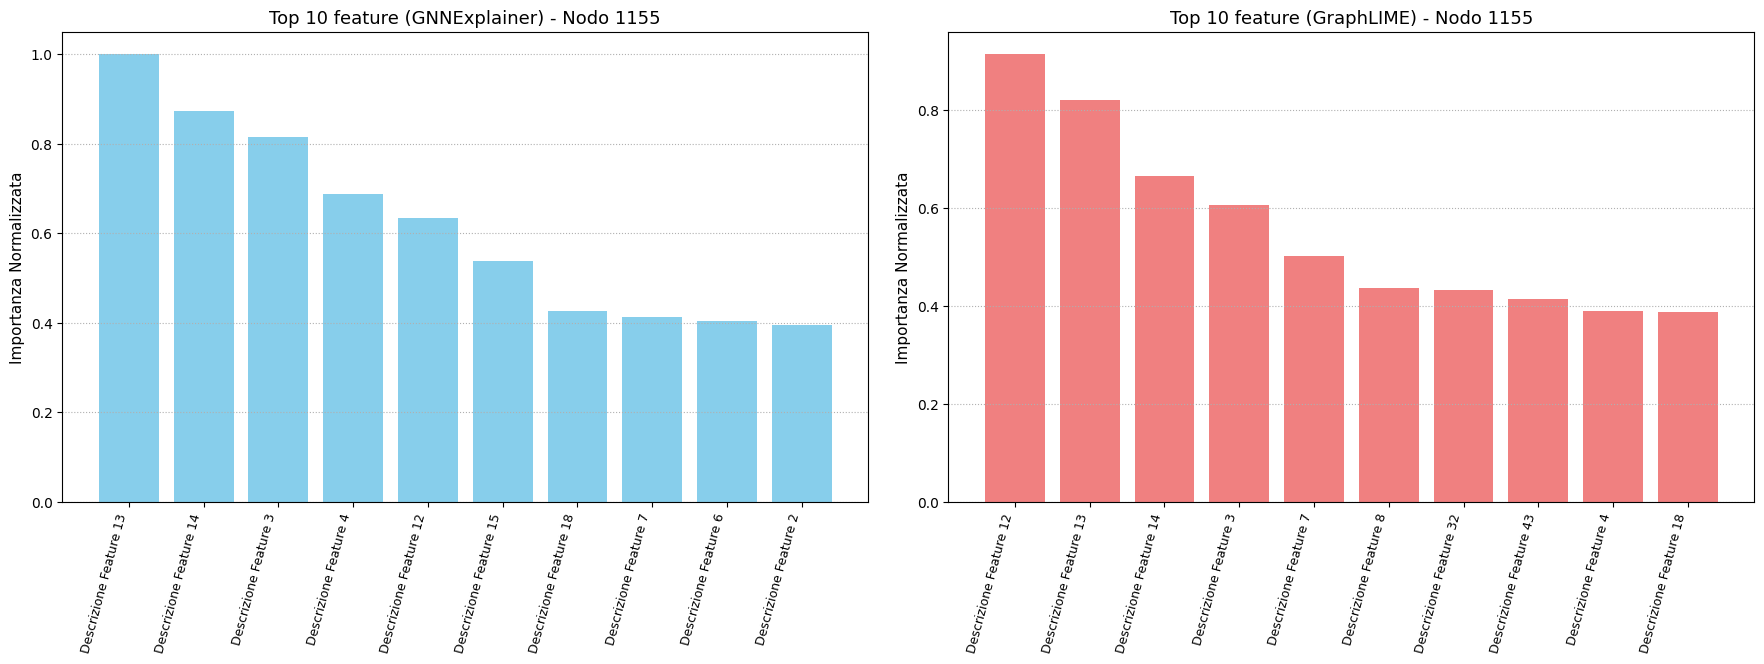

Sovrapposizione tra le top 20 feature: 12 feature (60.0%)
Feature in comune: [1, 2, 3, 6, 7, 11, 12, 13, 16, 17, 18, 31]
Correlazione di Pearson tra GNNExplainer e GraphLIME per nodo 1155: 0.7223


In [28]:
# ----------------------------------------------------------------------------------
# CELLA 25: Confronto Specifico GNNExplainer vs GraphLIME
# ----------------------------------------------------------------------------------
if 'data' in locals() and data.x.shape[0] > 0 and \
   'model' in locals() and \
   'node_feature_descriptions_llm' in locals() and \
   'graph_lime' in locals() and \
   'reports_path' in locals(): # Aggiunto controllo per variabili necessarie

    tumor_nodes_indices = []
    with torch.no_grad():
        # Assicurati che 'outputs' dalla Cella 10 sia disponibile o ricalcola se necessario
        if 'outputs' not in locals() or outputs is None:
            logging.warning("La variabile 'outputs' non è definita, la ricalcolo per la Cella 25.")
            outputs_for_cell25 = model(data.x, data.edge_index.type(torch.int64))
        else:
            outputs_for_cell25 = outputs

        all_predicted_labels = outputs_for_cell25.argmax(dim=1)
        for i, label in enumerate(all_predicted_labels):
            if label.item() > 0: # Classi 1, 2, o 3
                tumor_nodes_indices.append(i)

    example_node_idx = -1 # Default
    if tumor_nodes_indices:
        example_node_idx = random.choice(tumor_nodes_indices)
    elif data.x.shape[0] > 0 : 
        example_node_idx = random.choice(range(data.x.shape[0]))
    
    if example_node_idx != -1:
        logging.info(f"Nodo di esempio per confronto GNNExplainer/GraphLIME: {example_node_idx}")
        logging.info(f"Classe predetta per nodo {example_node_idx}: {all_predicted_labels[example_node_idx].item()}")

        # Assicurati che le funzioni explainer siano definite (Cella 11 e Cella 12/14 per graph_lime)
        gnn_expl_compare, _ = gnn_explainer_simple(example_node_idx, data.x, data.edge_index)
        lime_expl_compare, _ = graph_lime.explain_node(example_node_idx, data.x, data.edge_index)

        gnn_importance_compare = gnn_expl_compare.abs()
        lime_importance_compare = lime_expl_compare.abs()
        
        # Normalizzazione (evita divisione per zero se tutte le importanze sono zero)
        if gnn_importance_compare.sum() > 1e-8: 
            gnn_importance_compare /= (gnn_importance_compare.max() + 1e-8)
        else: # Se tutte le importanze sono zero, lasciale come tensore di zeri
            gnn_importance_compare = torch.zeros_like(gnn_importance_compare)

        if lime_importance_compare.sum() > 1e-8: 
            lime_importance_compare /= (lime_importance_compare.max() + 1e-8)
        else:
            lime_importance_compare = torch.zeros_like(lime_importance_compare)


        plt.figure(figsize=(18, 7))
        top_n_compare = 10

        plt.subplot(1, 2, 1)
        top_indices_gnn_c = torch.argsort(gnn_importance_compare, descending=True)[:top_n_compare]
        plt.bar(range(top_n_compare), gnn_importance_compare[top_indices_gnn_c].cpu().numpy(), color='skyblue')
        # USA node_feature_descriptions_llm DEFINITA NELLA CELLA 18.1
        plt.xticks(range(top_n_compare), [node_feature_descriptions_llm.get(i.item(), f"F{i.item()}") for i in top_indices_gnn_c], rotation=75, ha='right', fontsize=9)
        plt.title(f"Top {top_n_compare} feature (GNNExplainer) - Nodo {example_node_idx}", fontsize=13)
        plt.ylabel("Importanza Normalizzata", fontsize=11)
        plt.grid(axis='y', linestyle=':')

        plt.subplot(1, 2, 2)
        top_indices_lime_c = torch.argsort(lime_importance_compare, descending=True)[:top_n_compare]
        plt.bar(range(top_n_compare), lime_importance_compare[top_indices_lime_c].cpu().numpy(), color='lightcoral')
        # USA node_feature_descriptions_llm DEFINITA NELLA CELLA 18.1
        plt.xticks(range(top_n_compare), [node_feature_descriptions_llm.get(i.item(), f"F{i.item()}") for i in top_indices_lime_c], rotation=75, ha='right', fontsize=9)
        plt.title(f"Top {top_n_compare} feature (GraphLIME) - Nodo {example_node_idx}", fontsize=13)
        plt.ylabel("Importanza Normalizzata", fontsize=11)
        plt.grid(axis='y', linestyle=':')

        plt.tight_layout(pad=2.0)
        
        # Assicurati che reports_path sia definito e sia una directory
        if not os.path.isdir(reports_path):
            os.makedirs(reports_path, exist_ok=True)
            logging.info(f"Creata cartella reports: {reports_path}")

        comparison_fig_path = os.path.join(reports_path, f'gnnexplainer_vs_graphlime_node{example_node_idx}.png')
        plt.savefig(comparison_fig_path, dpi=300)
        logging.info(f"Plot di confronto GNNExplainer/GraphLIME salvato in: {comparison_fig_path}")
        plt.show()

        top_n_overlap = 20 
        top_indices_gnn_set_c = set(torch.argsort(gnn_importance_compare, descending=True)[:top_n_overlap].cpu().numpy())
        top_indices_lime_set_c = set(torch.argsort(lime_importance_compare, descending=True)[:top_n_overlap].cpu().numpy())
        overlap_c = top_indices_gnn_set_c.intersection(top_indices_lime_set_c)
        overlap_percentage_c = (len(overlap_c) / top_n_overlap * 100) if top_n_overlap > 0 else 0
        print(f"Sovrapposizione tra le top {top_n_overlap} feature: {len(overlap_c)} feature ({overlap_percentage_c:.1f}%)")
        print(f"Feature in comune: {sorted(list(overlap_c))}")

        if gnn_importance_compare.std() > 1e-8 and lime_importance_compare.std() > 1e-8: # Modificato per evitare std zero
            gnn_norm_c = (gnn_importance_compare - gnn_importance_compare.mean()) / (gnn_importance_compare.std() + 1e-8)
            lime_norm_c = (lime_importance_compare - lime_importance_compare.mean()) / (lime_importance_compare.std() + 1e-8)
            corr_c = (gnn_norm_c * lime_norm_c).mean().item()
            print(f"Correlazione di Pearson tra GNNExplainer e GraphLIME per nodo {example_node_idx}: {corr_c:.4f}")
        else:
            print(f"Impossibile calcolare la correlazione per nodo {example_node_idx} (deviazione standard nulla o vicina a zero per una o entrambe le importanze).")
    else:
        logging.warning("Nessun nodo di esempio disponibile per il confronto GNNExplainer vs GraphLIME.")
else:
    logging.error("Variabili necessarie ('data', 'model', 'node_feature_descriptions_llm', 'graph_lime', 'reports_path') "
                  "non definite per la Cella 25. Assicurati che le celle precedenti siano eseguite.")